<a href="https://colab.research.google.com/github/mariateonaolteanu23/AccessRoute/blob/master/data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Data Preparation and Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import layers
import tensorflow as tf
import os
import cv2
import shutil
import matplotlib.image as mpimg
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D, GlobalAveragePooling2D, Resizing
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from datetime import datetime
import random

## Data Loading and Structure Understanding

### Use personal drive to store data


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Define paths for data loading

In [3]:
FOLDER = "/content/drive/MyDrive/dl-partA/"
LABEL_DESC_FILE = "Label.txt"
IMAGES_FOLDER = "Image/"

### Because we have to classification tasks (roll and pitch) we decided to combine the in a single task. The images will be labelled and associated based on the concatenation of pitch and roll values. (e.g. 0-70)

In [4]:
data = []

with open(f'{FOLDER}{LABEL_DESC_FILE}', 'r') as labels:
    for line in labels:
        splits = line.strip().split()

        # image specs
        pitch = splits[1]
        roll = splits[2]
        depth = splits[3]

        # determine image location
        img_path = f"{FOLDER}{IMAGES_FOLDER}{splits[0]}"

        # get image measurements
        h, w, chs = cv2.imread(img_path).shape

        # create label folder based on the combination of pitch and roll
        label_folder = f"{FOLDER}data/{pitch}_{roll}"

        if not os.path.exists(label_folder):
            os.makedirs(label_folder)

        # copy image in the label folder
        shutil.copy2(img_path, f"{label_folder}/{splits[0]}")

        # create dataframe entry of image specs and properties
        data.append({"img":  f"{label_folder}/{splits[0]}",
                     "label": f"{pitch}_{roll}",
                     "pitch": pitch,
                     "roll": roll,
                     "depth": depth,
                     "height": h,
                     "width": w,
                     "channels": chs})

    # create and store dataframe
    df = pd.DataFrame(data)
    df.to_csv(f"{FOLDER}img_desc.csv", index=False)

KeyboardInterrupt: 

# Exploratory Data Analysis

In [4]:
df = pd.read_csv(f"{FOLDER}img_desc.csv")
df.head()

img label  pitch  roll  \
0  /content/drive/MyDrive/dl-partA/data/0_0/6_P0_...   0_0      0     0   
1  /content/drive/MyDrive/dl-partA/data/0_0/6_P0_...   0_0      0     0   
2  /content/drive/MyDrive/dl-partA/data/0_0/6_P0_...   0_0      0     0   
3  /content/drive/MyDrive/dl-partA/data/0_0/6_P0_...   0_0      0     0   
4  /content/drive/MyDrive/dl-partA/data/0_0/6_P0_...   0_0      0     0   

      depth  height  width  channels  init_depth  
0  0.223637     256    256         3    0.223637  
1  0.386035     256    256         3    0.386035  
2 -0.084372     256    256         3   -0.084372  
3 -0.788439     256    256         3   -0.788439  
4 -0.406647     256    256         3   -0.406647

All images are 256 x 256.

In [6]:
print(df['height'].unique())
print(df['width'].unique())

[256]
[256]


### Create plots to visualize data distribution

In [7]:
PLOTS_FOLDER = f"{FOLDER}/plots/"
os.makedirs(PLOTS_FOLDER, exist_ok=True)

Depth Values distribution

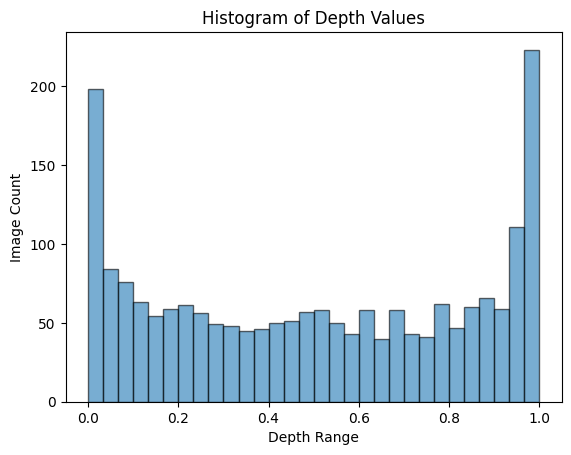

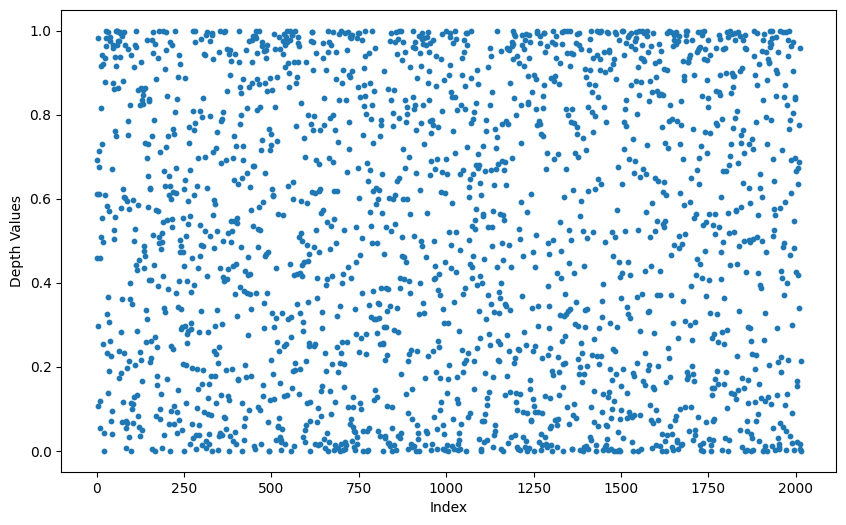

In [8]:
plt.hist(df["depth"], bins=30, edgecolor='k', alpha=0.6)
plt.title('Histogram of Depth Values')
plt.xlabel('Depth Range')
plt.ylabel('Image Count')
plt.savefig(f"{PLOTS_FOLDER}depth")
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(df["depth"])), df["depth"], s=10)
plt.xlabel("Index")
plt.ylabel("Depth Values")
plt.show()

Pitch and Roll distribution

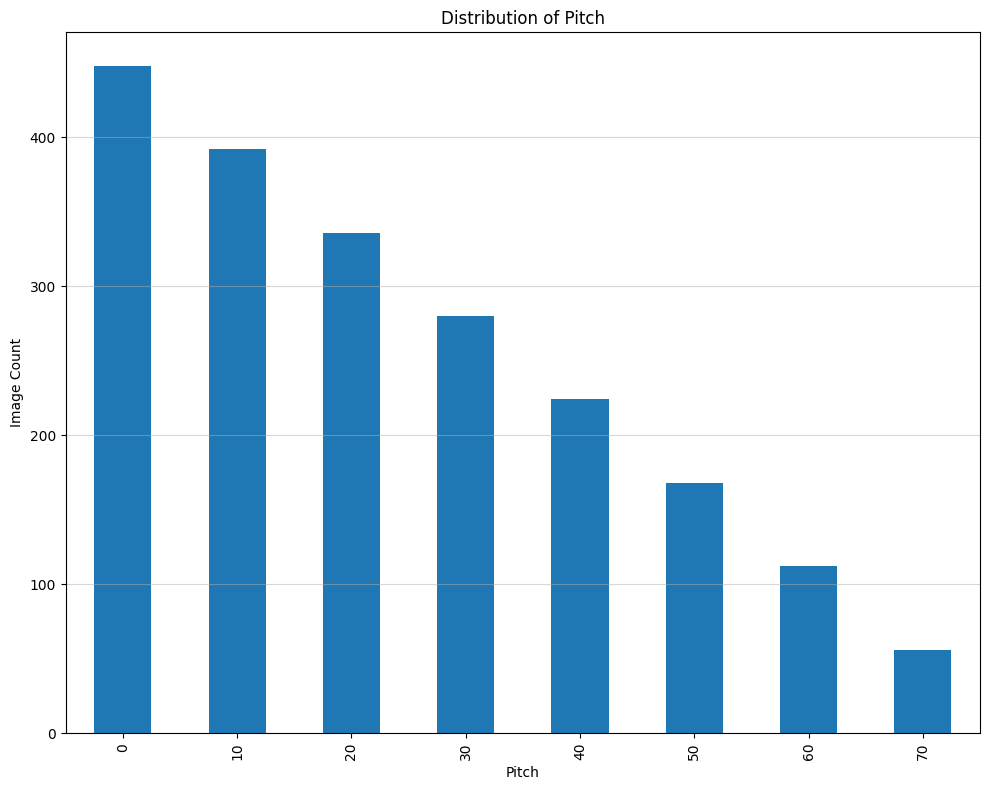

In [10]:
plt.figure(figsize=(10, 8))
df['pitch'].value_counts().plot(kind='bar')
plt.title('Distribution of Pitch')
plt.xlabel('Pitch')
plt.ylabel('Image Count')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig(f"{PLOTS_FOLDER}pitch")
plt.show()

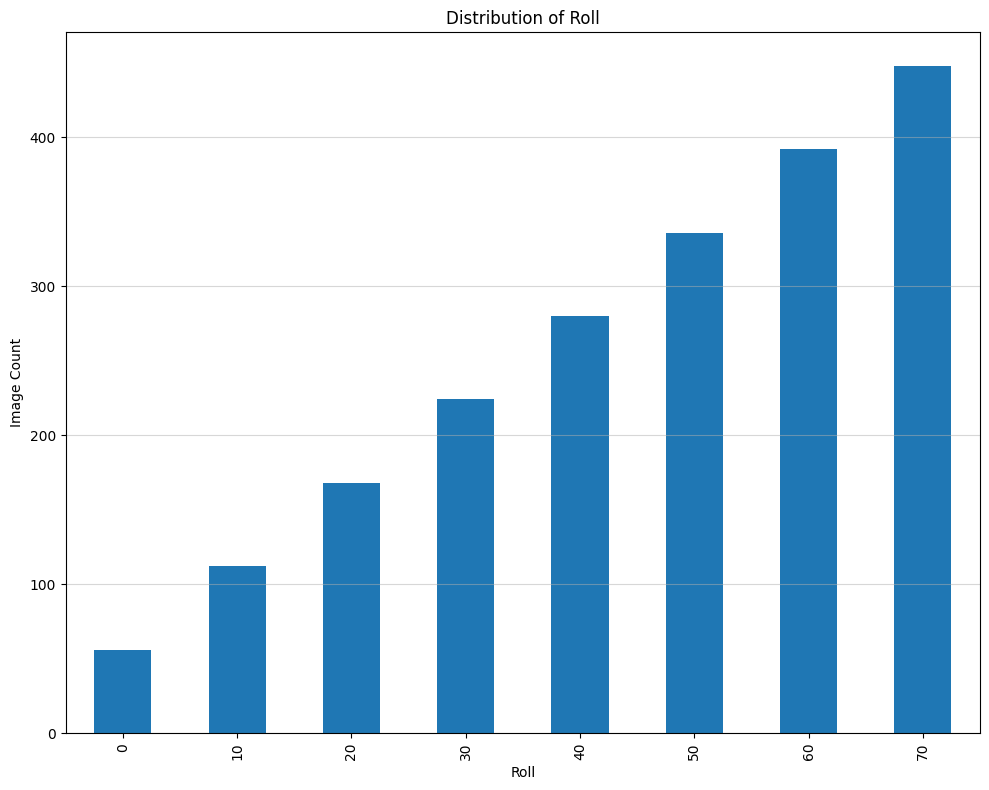

In [19]:
plt.figure(figsize=(10, 8))
df['roll'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Roll')
plt.xlabel('Roll')
plt.ylabel('Image Count')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig(f"{PLOTS_FOLDER}roll")
plt.show()

Distribution of labels

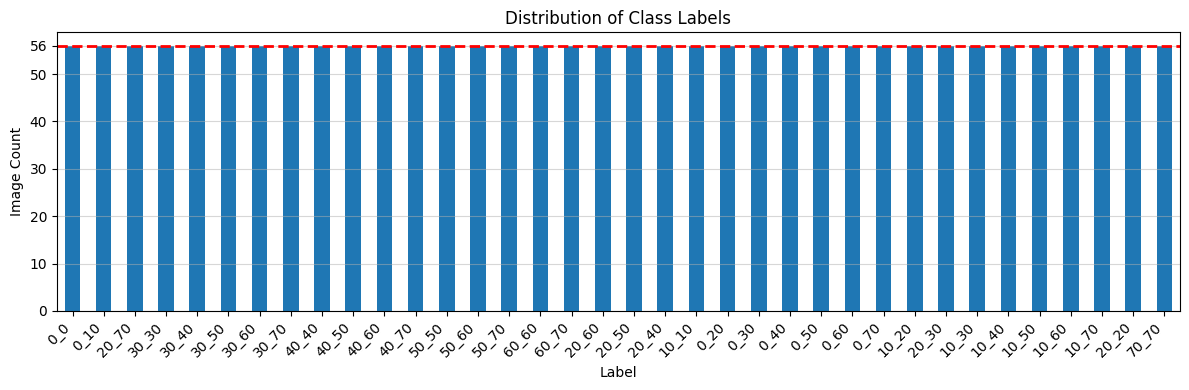

In [12]:
plt.figure(figsize=(12, 4))
df['label'].value_counts().plot(kind='bar')
plt.axhline(y=df['label'].value_counts().values[0], color='red', linestyle='--', linewidth=2)
plt.title('Distribution of Class Labels')
plt.xlabel('Label')
plt.ylabel('Image Count')
plt.yticks([0, 10, 20, 30, 40, 50, 56])
plt.xticks(rotation=45, fontsize=10, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.savefig(f"{PLOTS_FOLDER}labels")
plt.show()

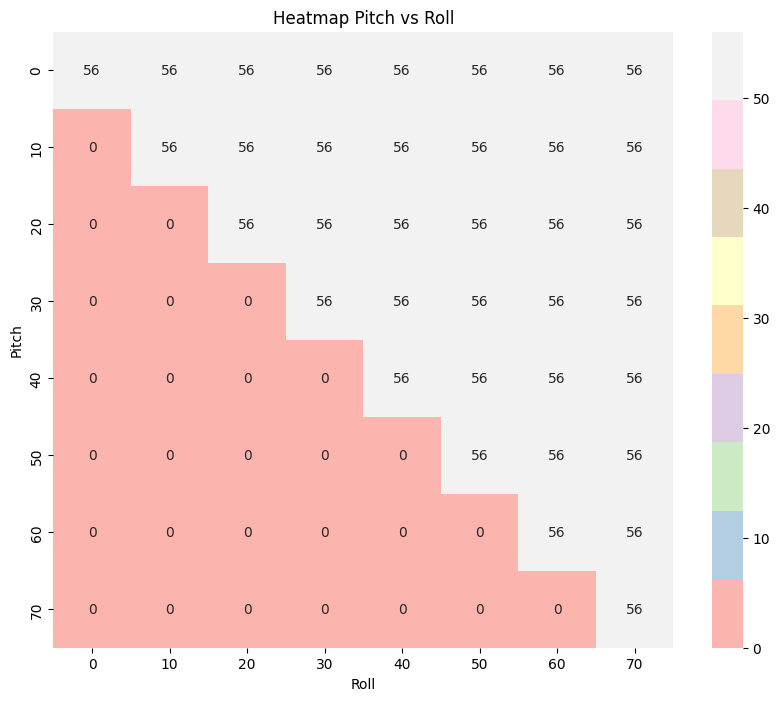

In [13]:
poses = df.groupby(['pitch', 'roll']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 8))
sns.heatmap(poses, annot=True, cmap="Pastel1")
plt.title("Heatmap Pitch vs Roll")
plt.xlabel("Roll")
plt.ylabel("Pitch")
plt.savefig(f"{PLOTS_FOLDER}labels_map")
plt.show()

### Visualization of sample images - plot different poses (combinations of pitch and roll)

<ipython-input-14-bad21342babe>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img = mpimg.imread(tmp.iloc[0][0])


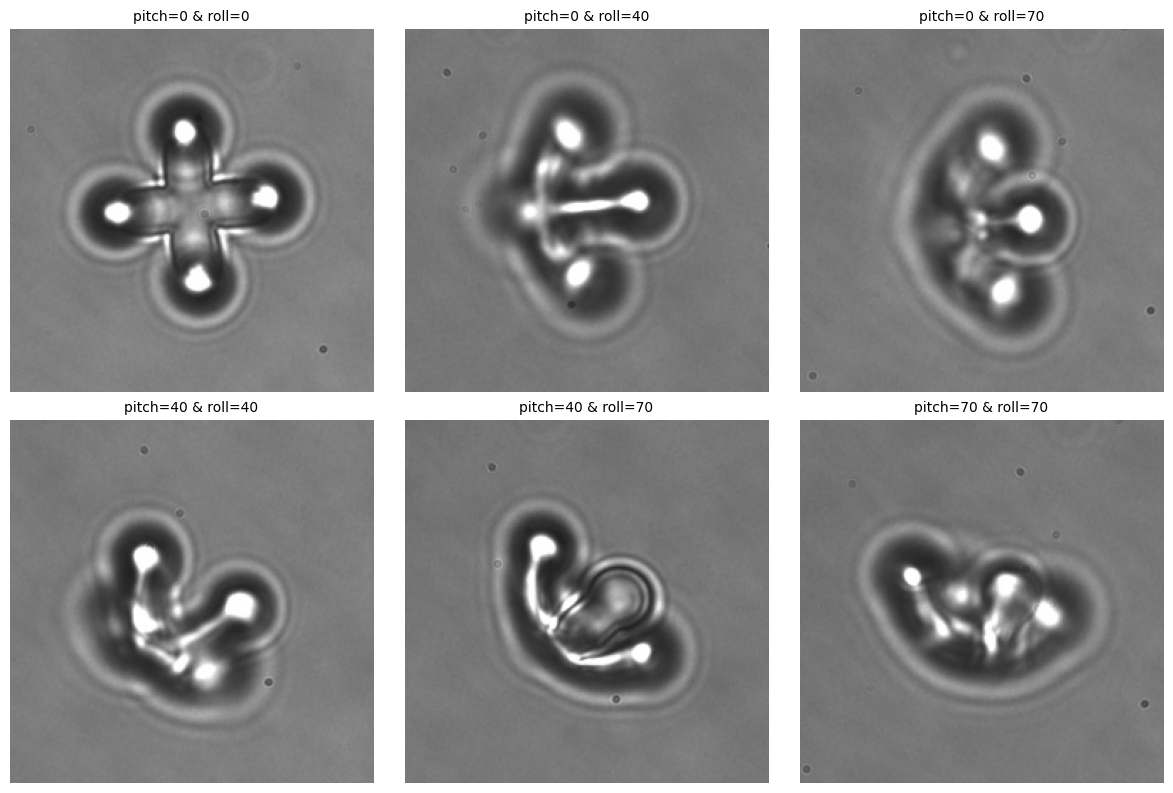

In [14]:
pitch_roll_combs = [(0, 0), (0, 40), (0, 70), (40, 40), (40, 70), (70, 70)]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, (p, r) in enumerate(pitch_roll_combs):
    label = f"{p}_{r}"

    tmp = df[df["label"] == label].copy()
    img = mpimg.imread(tmp.iloc[0][0])
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"pitch={p} & roll={r}", fontsize=10)
plt.tight_layout()
plt.savefig(f"{PLOTS_FOLDER}images")
plt.show()

### **Data Augumentation Exploration**
-----
Manipulate depth perception using depth maps and brightness

In [6]:
def brighten_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 140, 255, cv2.THRESH_BINARY)
    mask = (mask / 255).astype(np.uint8)
    new_image = image.copy()
    new_image[mask == 1] = np.clip(image[mask == 1] * 2.5, 0, 255)
    return new_image

from sklearn.utils import shuffle
def aug_image(image):
  channels = cv2.split(image)
  l_channels = []
  for channel in channels:
    channel = channel.astype(np.uint8)
    b_channel = cv2.GaussianBlur(channel, (3, 3), 0)
    l_channels.append(cv2.Laplacian(b_channel, cv2.CV_64F))

  n_channels = []
  for channel in l_channels:
    mini = np.min(channel)
    maxi = np.max(channel)
    n_channels.append(((channel - mini) / (maxi - mini) * 255).astype(np.uint8))

  depth_map = cv2.merge(n_channels)

  images = []
  for alpha in [0.4, 0.6, 0.8]:
    beta = 1 - alpha
    aug_image = cv2.addWeighted(image, alpha, depth_map, beta, 0)
    images.append(aug_image)
  return images

def augment_dataset(dataset):
    X = []
    y = []

    for images, targets in dataset:
        X.append(images.numpy())
        y.append(targets.numpy())

    aug_X = []
    aug_y = []

    for i in range(len(X)):
        Xs = aug_image(X[i])
        for x in Xs:
          aug_X.append(x)
          aug_y.append(y[i])

    # indices = np.random.permutation(len(aug_X))
    # return np.array(aug_X[indices]), np.array(aug_Y[indices])

    aug_X, aug_y = shuffle(aug_X, aug_y, random_state=42)
    return tf.data.Dataset.from_tensor_slices((aug_X, aug_y))

<ipython-input-7-640466a71bbe>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = cv2.imread(tmp.iloc[3][0])


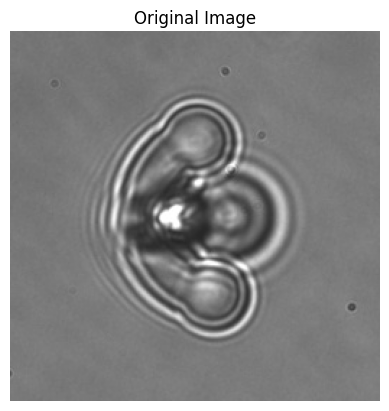

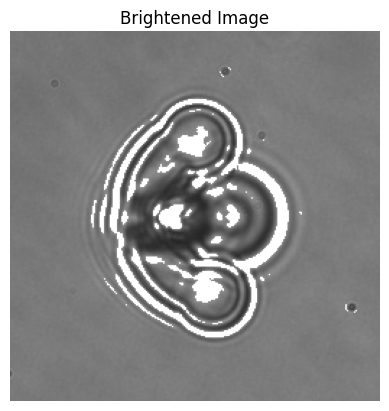

<ipython-input-7-640466a71bbe>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  images = aug_image(cv2.imread(tmp.iloc[3][0]))


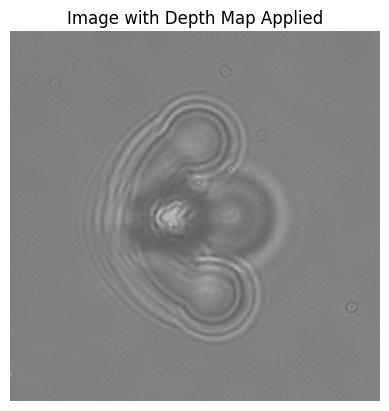

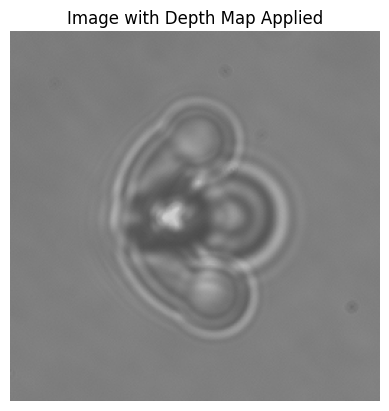

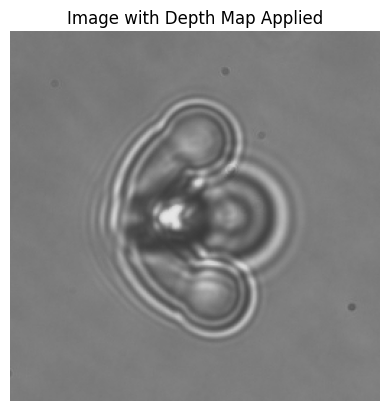

<ipython-input-7-640466a71bbe>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = cv2.imread(tmp.iloc[0][0])


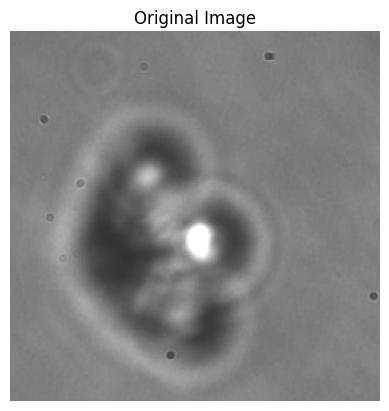

<ipython-input-7-640466a71bbe>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  images = aug_image(cv2.imread(tmp.iloc[1][0]))


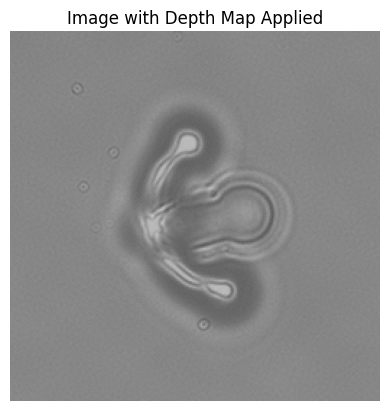

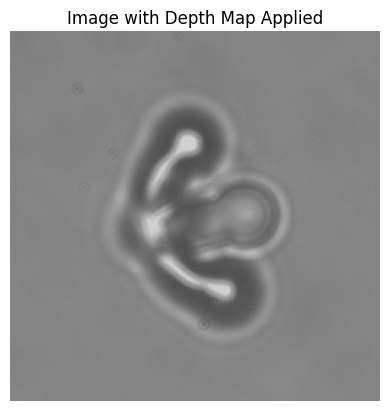

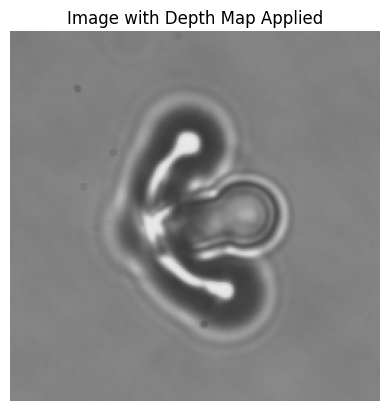

In [7]:
label = f"0_70"
tmp = df[df["label"] == label]

image = cv2.imread(tmp.iloc[3][0])
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.show()

image = brighten_image(image)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Brightened Image')
plt.show()


images = aug_image(cv2.imread(tmp.iloc[3][0]))

for img in images:
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title('Image with Depth Map Applied')
  plt.show()

label = f"10_60"
tmp = df[df["label"] == label]
image = cv2.imread(tmp.iloc[0][0])
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.show()

images = aug_image(cv2.imread(tmp.iloc[1][0]))
for img in images:
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title('Image with Depth Map Applied')
  plt.show()

### **Normalization/Standardization and Splitting**
---

#### **Resize and Normalize the image**

Resized the image to 100 x 100 and normalized it by centering it (substract mean) and scaling pixel values between [-1, 1] (the image is not clipped).

<ipython-input-12-f2319fd16e42>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = cv2.imread(tmp.iloc[0][0])


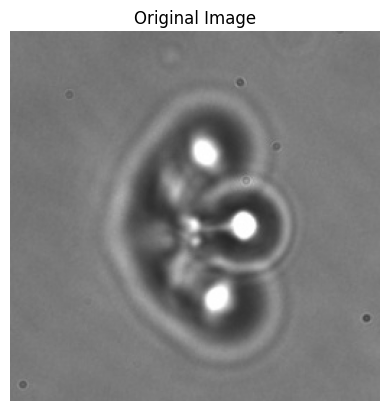

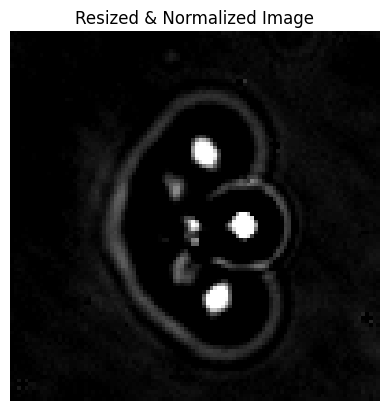

In [12]:
def resize_img(image, h=100, w=100):
  return cv2.resize(image, (w, h))

def normalize_img(image):
  return ((image - np.mean(image)) / 127)

label = f"0_70"
tmp = df[df["label"] == label]

image = cv2.imread(tmp.iloc[0][0])
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Original Image')
plt.show()

image = resize_img(image)
image = normalize_img(image)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title('Resized & Normalized Image')
plt.show()

### **Depth Standardization + Normalization**

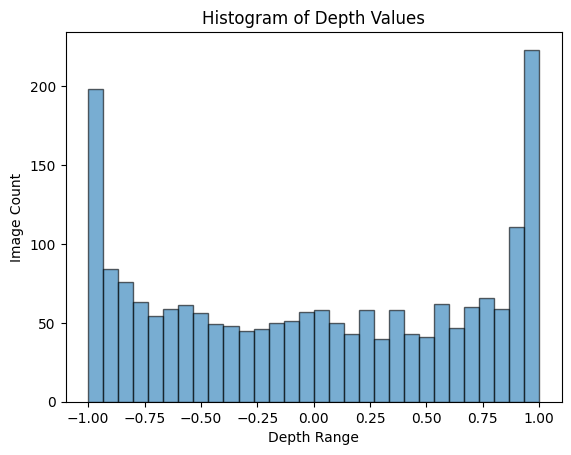

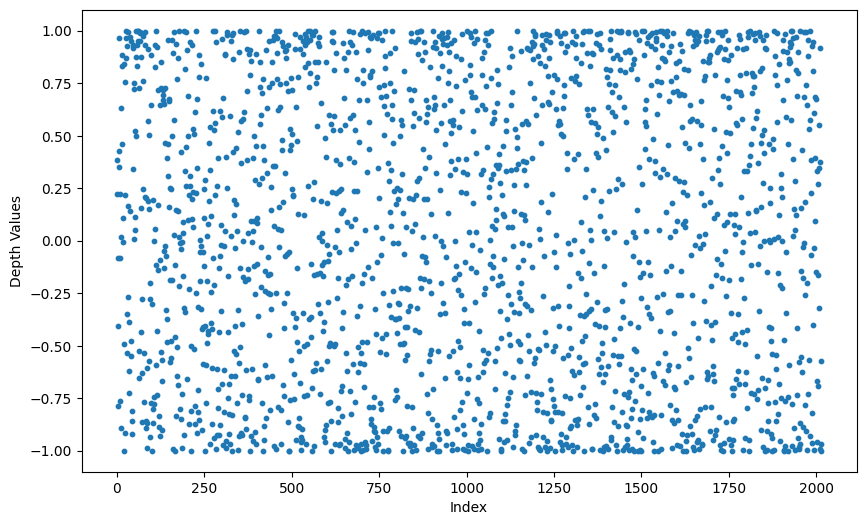

img label  pitch  roll  \
0  /content/drive/MyDrive/dl-partA/data/0_0/6_P0_...   0_0      0     0   
1  /content/drive/MyDrive/dl-partA/data/0_0/6_P0_...   0_0      0     0   
2  /content/drive/MyDrive/dl-partA/data/0_0/6_P0_...   0_0      0     0   
3  /content/drive/MyDrive/dl-partA/data/0_0/6_P0_...   0_0      0     0   
4  /content/drive/MyDrive/dl-partA/data/0_0/6_P0_...   0_0      0     0   

      depth  height  width  channels  init_depth  
0  0.223637     256    256         3    0.223637  
1  0.386035     256    256         3    0.386035  
2 -0.084372     256    256         3   -0.084372  
3 -0.788439     256    256         3   -0.788439  
4 -0.406647     256    256         3   -0.406647

In [18]:
depth_std = (df['depth'] - df['depth'].mean()) / df['depth'].std()
depth_norm = 2 * (depth_std - depth_std.min()) / (depth_std.max() - depth_std.min()) - 1

plt.hist(depth_norm, bins=30, edgecolor='k', alpha=0.6)
plt.title('Histogram of Depth Values')
plt.xlabel('Depth Range')
plt.ylabel('Image Count')
plt.savefig(f"{PLOTS_FOLDER}depth")
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(range(len(depth_norm)), depth_norm, s=10)
plt.xlabel("Index")
plt.ylabel("Depth Values")
plt.show()

df["init_depth"] = df['depth']
df['depth'] = depth_norm
df.to_csv(f"{FOLDER}img_desc.csv", index=False)
df.head()

### **Split Logic**

In [9]:
def split_data(dataset, test_size=0.2, val_size=0.2, strat=True):
  X = []
  y = []

  for images, targets in dataset:
      X.append(images.numpy())
      y.append(targets.numpy())

  X = np.concatenate(X, axis=0)
  y = np.concatenate(y, axis=0)

  if strat:
    stratify = y
  else:
    stratify = None

  X, X_test, y, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=stratify, shuffle=True)

  if strat:
    stratify = y
  else:
    stratify = None

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state=42, stratify=stratify, shuffle=True)

  return  X_train, X_val, X_test, y_train, y_val, y_test

def split_dataset(dataset, test_size=0.2, val_size=0.2, strat=True):

  X_train, X_val, X_test, y_train, y_val, y_test = split_data(dataset, test_size=test_size, val_size=val_size, strat=strat)

  train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
  val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
  test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

  return train_dataset, val_dataset, test_dataset

### **Create Datasets**
Create dataset for microbot pose classification

In [10]:
def normalize_img(image):
    image = tf.cast(image, tf.float32)
    return (image - tf.reduce_mean(image)) / 127.0

def create_poses_datasets(dir=f"{FOLDER}/data", image_size=(256, 256), normalize=True, augment=False, test_size=0.2, val_size=0.2, strat=True):

  dataset = tf.keras.utils.image_dataset_from_directory(
        dir,
        labels='inferred',
        label_mode='categorical',
        image_size=image_size
  )

  labels = dataset.class_names

  train_dataset, val_dataset, test_dataset = split_dataset(dataset, test_size=test_size, val_size=val_size, strat=strat)

  if augment:
    train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.uint8), y))
    train_dataset = augment_dataset(train_dataset)

  if normalize:
    train_dataset = train_dataset.map(lambda x, y: (normalize_img(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(lambda x, y: (normalize_img(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.map(lambda x, y: (normalize_img(x), y), num_parallel_calls=tf.data.AUTOTUNE)

  train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
  val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

  return labels, train_dataset, val_dataset, test_dataset

Create dataset for depth prediction (regression task)

In [11]:
def get_image(path, normalize=True):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    if normalize:
      image = normalize_img(image)
    return image

def create_depth_datasets(df, image_size=(100, 100), normalize=True, test_size=0.2, val_size=0.2, strat=False, batch_size=16):
  dataset = tf.data.Dataset.from_tensor_slices((df["img"], df["depth"]))
  dataset = dataset.map(lambda x, y: (get_image(x, normalize=normalize), y), num_parallel_calls=tf.data.AUTOTUNE)
  dataset = dataset.batch(batch_size)
  train_dataset, val_dataset, test_dataset = split_dataset(dataset, test_size=test_size, val_size=val_size, strat=strat)

  return train_dataset, val_dataset, test_dataset

# depth_dataset = create_depth_dataset(df)
# for images, targets in depth_dataset.take(1):
#     print(images.shape, targets.shape)
#     print(targets[0])
#     plt.imshow(images[0])
#     plt.axis("off")
#     plt.show()

# **Classification Task**
---

In [12]:
# Credits: Google Colab
info = !nvidia-smi
info = '\n'.join(info)
if info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(info)

Fri Dec 20 12:47:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Define basic CNN models: 2 x models with 2 convolutional layers, 1 model with 3 convolutional layers.

In [49]:
class CNN2(tf.keras.Model):
    def __init__(self, input_shape, num_classes, dropout_rate=0.5):
        super(CNN2, self).__init__()
        self.resize = Resizing(64, 64)
        self.conv1 = Conv2D(32, (3, 3), activation='relu')
        self.pool1 = MaxPooling2D((2, 2))

        self.conv2 = Conv2D(64, (3, 3), activation='relu')
        self.pool2 = MaxPooling2D((2, 2))

        self.flatten = Flatten()
        self.dense1 = Dense(128, activation='relu')
        self.dropout = Dropout(dropout_rate)
        self.out = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.resize(inputs)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout(x, training=training)
        outs = self.out(x)
        return outs

class CNN2_(tf.keras.Model):
    def __init__(self, input_shape, num_classes, dropout_rate=0.2):
        super(CNN2_, self).__init__()
        # first conv layer
        self.resize = Resizing(64, 64)
        self.conv1 = Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)
        self.pool1 = MaxPooling2D((2, 2))

        # second conv layer
        self.conv2 = Conv2D(64, (3, 3), activation='relu')
        self.pool2 = MaxPooling2D((2, 2))

        self.avg_pool_g = GlobalAveragePooling2D()

        self.dense = Dense(128, activation='relu')
        self.dropout = Dropout(dropout_rate)
        self.out = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.resize(inputs)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.avg_pool_g(x)
        x = self.dense(x)
        x = self.dropout(x, training=training)
        outs = self.out(x)
        return outs

class CNN3(tf.keras.Model):
    def __init__(self, input_shape, num_classes, dropout_rate=0.5):
        super(CNN3, self).__init__()
        self.resize = Resizing(64, 64)
        # first conv layer
        self.conv1 = Conv2D(32, (3, 3), activation='relu', input_shape=input_shape)
        self.pool1 = MaxPooling2D((2, 2))

        # second conv layer
        self.conv2 = Conv2D(64, (3, 3), activation='relu')
        self.pool2 = MaxPooling2D((2, 2))

        # third conv layer
        self.conv3 = Conv2D(128, (3, 3), activation='relu')
        self.pool3 = MaxPooling2D((2, 2))

        self.flatten = Flatten()
        self.dense = Dense(128, activation='relu')
        self.dropout = Dropout(dropout_rate)

        self.out = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.resize(inputs)
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dropout(x, training=training)
        outs = self.out(x)
        return outs

In [50]:
from matplotlib.ticker import MaxNLocator

def get_model(name, input_shape, num_classes):
  if name == "cnn2":
    return CNN2(input_shape, num_classes)
  elif name == "cnn2_":
    return CNN2_(input_shape, num_classes)
  elif name == "cnn3":
    return CNN3(input_shape, num_classes)
  else:
    raise Exception("Model does not exist")

def get_classes(x):
  return np.argmax(x, axis=1)

def evaluate_model(model, labels, X_test, y_test, path=""):
  loss, accuracy = model.evaluate(X_test, y_test)
  print(f"Test Loss: {loss}")

  y_pred = model.predict(X_test)
  y_pred = get_classes(y_pred)
  y_true = get_classes(y_test)

  acc = accuracy_score(y_true, y_pred)
  print(f"Test Accuracy: {acc}")

  precision = precision_score(y_true, y_pred, average="weighted")
  print(f"Test Precision: {precision}")

  recall = recall_score(y_true, y_pred, average="weighted")
  print(f"Test Recall: {recall}")

  f1 = f1_score(y_true, y_pred, average="weighted")
  print(f"Test F1 Score: {f1}")

  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, linewidths=0.5, linecolor='gray', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Labels')
  plt.ylabel('Actual Labels')
  plt.title('Confusion Matrix')
  plt.tight_layout()
  plt.savefig(path)
  plt.show()

  return acc, precision, recall, f1

def store_results(data, model, results):
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
  results["time"] = timestamp
  results["model"] = model
  data.append(results)
  return data

def comparison_plot(history, title, m1, m2, save=False, file="plot"):
  plt.plot(range(1, len(history[m1]) + 1), history[m1], label=f'Training {title.split()[0]}')
  plt.plot(range(1, len(history[m1]) + 1), history[m2], label=f'Validation {title.split()[0]}')
  plt.xlabel('Epochs')
  plt.ylabel(f'{title.split()[0]}')
  plt.title(f'Training vs Validation {title}')
  ax = plt.gca()
  ax.xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend()
  plt.grid(True)
  if save:
    plt.savefig(file)
  plt.show()

def plot_training_metrics(model_history, folder, models=["cnn2", "cnn2_", "cnn3"], save=False):
  os.makedirs(folder, exist_ok=True)

  for model_type in models:
    epochs = [5, 10, 20, 30]
    print(f"MODEL {model_type}")
    for i, history in enumerate(model_history[model_type]):
        comparison_plot(history.history, f"Loss", 'loss', 'val_loss', save=save, file=f"{folder}{model_type}-loss-ep{epochs[i]}")
        comparison_plot(history.history, f"Accuracy", 'accuracy', 'val_accuracy', save=save, file=f"{folder}{model_type}-acc-ep{epochs[i]}")

Get train, validation and test datasets for classification task

In [32]:
labels, train_dataset, val_dataset, test_dataset = create_poses_datasets(dir=f"{FOLDER}/data", normalize=True, strat=True, augment=True)

Found 2016 files belonging to 36 classes.


In [33]:
BATCH_SIZE = 16
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [44]:
X_test = []
y_test = []
for feature_batch, label_batch in test_dataset.as_numpy_iterator():
    X_test.append(feature_batch)
    y_test.append(label_batch)

X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0)

Train & Evaluate 3 Basic CNN Models

Epoch 1/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1801 - loss: 3.0109 - val_accuracy: 0.9009 - val_loss: 0.3200
Epoch 2/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7649 - loss: 0.7448 - val_accuracy: 0.9536 - val_loss: 0.1946
Epoch 3/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8810 - loss: 0.3728 - val_accuracy: 0.9690 - val_loss: 0.1509
Epoch 4/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9073 - loss: 0.2698 - val_accuracy: 0.9628 - val_loss: 0.1871
Epoch 5/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9214 - loss: 0.2402 - val_accuracy: 0.9598 - val_loss: 0.1544
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9806 - loss: 0.1510
Test Loss: 0.15160778164863586
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Test Accuracy: 0.9801980198019802
Test Precision: 0.9817303158887316
Test Recall: 0.9801980198019802
Test F1 Score: 0.9799584850732413


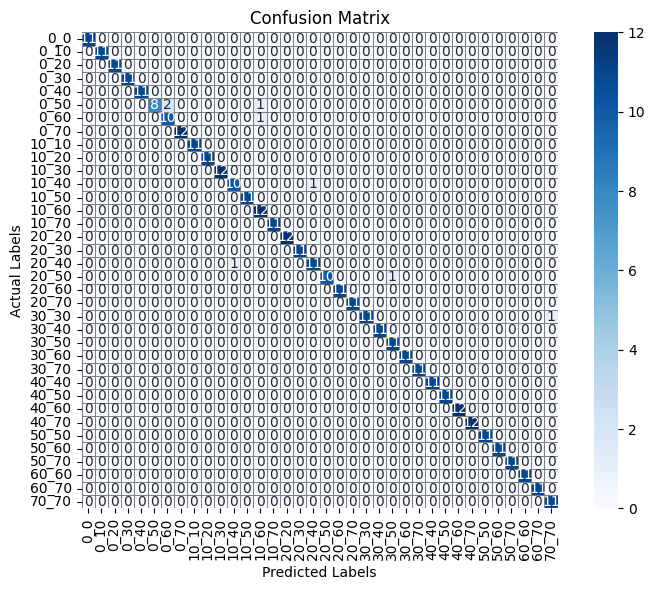

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1897 - loss: 2.9953 - val_accuracy: 0.9133 - val_loss: 0.3075
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7760 - loss: 0.7203 - val_accuracy: 0.9536 - val_loss: 0.1888
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8765 - loss: 0.3901 - val_accuracy: 0.9659 - val_loss: 0.1292
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9163 - loss: 0.2521 - val_accuracy: 0.9659 - val_loss: 0.1506
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9283 - loss: 0.2018 - val_accuracy: 0.9598 - val_loss: 0.1907
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9356 - loss: 0.1898 - val_accuracy: 0.9690 - val_loss: 0.1574
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9472 - loss: 0.1567 - val_accuracy: 0.9721 - val_loss: 0.1684
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9498 - loss: 0.1384 - val_accuracy: 0

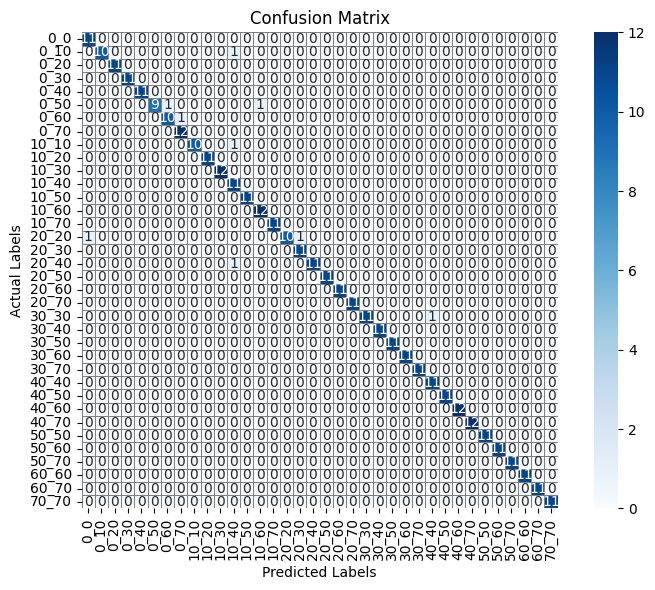

Epoch 1/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.1886 - loss: 3.0320 - val_accuracy: 0.8824 - val_loss: 0.3745
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7741 - loss: 0.7274 - val_accuracy: 0.9536 - val_loss: 0.1840
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8722 - loss: 0.3772 - val_accuracy: 0.9659 - val_loss: 0.1235
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8949 - loss: 0.2861 - val_accuracy: 0.9752 - val_loss: 0.0955
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9157 - loss: 0.2245 - val_accuracy: 0.9752 - val_loss: 0.1038
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9333 - loss: 0.1804 - val_accuracy: 0.9752 - val_loss: 0.1112
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9353 - loss: 0.1764 - val_accuracy: 0.9721 - val_loss: 0.1426
Epoch 8/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9349 - loss: 0.1766 - val_accuracy: 0

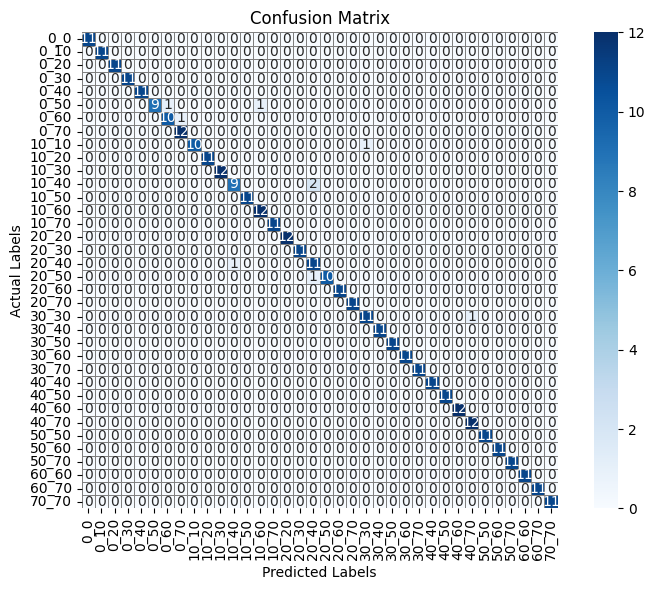

Epoch 1/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2318 - loss: 2.7875 - val_accuracy: 0.9133 - val_loss: 0.3085
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8225 - loss: 0.5633 - val_accuracy: 0.9412 - val_loss: 0.2143
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8874 - loss: 0.3387 - val_accuracy: 0.9567 - val_loss: 0.1569
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9246 - loss: 0.2420 - val_accuracy: 0.9598 - val_loss: 0.1445
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9300 - loss: 0.2091 - val_accuracy: 0.9659 - val_loss: 0.1621
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9345 - loss: 0.1824 - val_accuracy: 0.9628 - val_loss: 0.1784
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9486 - loss: 0.1438 - val_accuracy: 0.9752 - val_loss: 0.1468
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9449 - loss: 0.1419 - val_accuracy: 0

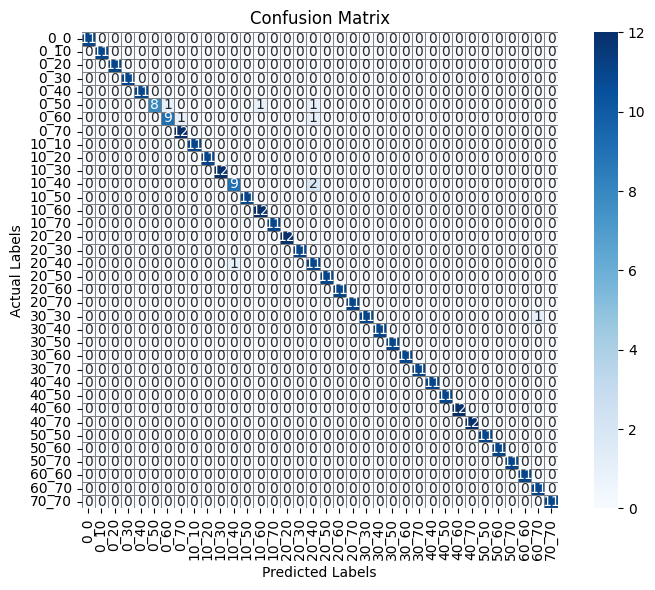

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.0491 - loss: 3.4871 - val_accuracy: 0.5666 - val_loss: 1.5368
Epoch 2/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3976 - loss: 1.9020 - val_accuracy: 0.9040 - val_loss: 0.3873
Epoch 3/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6349 - loss: 1.0695 - val_accuracy: 0.9690 - val_loss: 0.1577
Epoch 4/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7270 - loss: 0.7853 - val_accuracy: 0.9814 - val_loss: 0.1079
Epoch 5/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7819 - loss: 0.6128 - val_accuracy: 0.9783 - val_loss: 0.0852
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.9723 - loss: 0.1146
Test Loss: 0.09747036546468735
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Test Accuracy: 0.9752475247524752
Test Precision: 0.9771659171411646
Test Recall: 0.9752475247524752
Test F1 Score: 0.9751110774001432


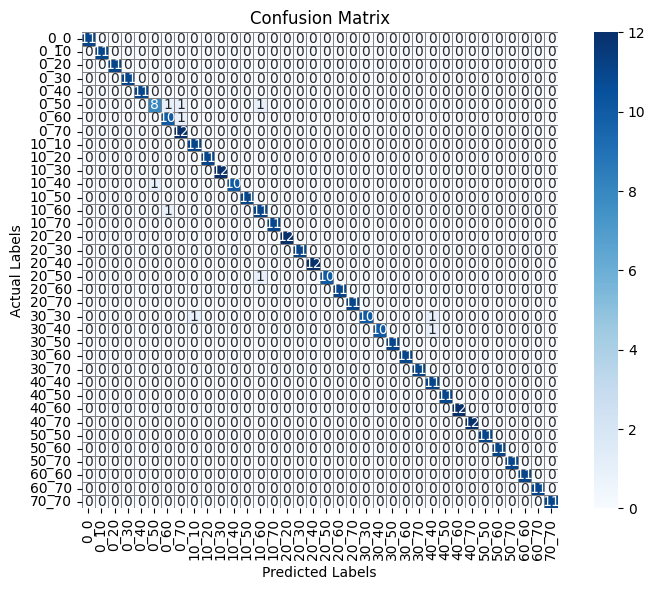

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.0756 - loss: 3.3860 - val_accuracy: 0.7399 - val_loss: 0.9794
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5583 - loss: 1.3748 - val_accuracy: 0.9474 - val_loss: 0.1903
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7574 - loss: 0.7031 - val_accuracy: 0.9752 - val_loss: 0.0869
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7885 - loss: 0.5622 - val_accuracy: 0.9721 - val_loss: 0.1019
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8389 - loss: 0.4577 - val_accuracy: 0.9814 - val_loss: 0.0566
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8578 - loss: 0.3839 - val_accuracy: 0.9721 - val_loss: 0.1071
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8700 - loss: 0.3588 - val_accuracy: 0.9876 - val_loss: 0.0356
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8808 - loss: 0.3235 - val_accuracy: 0.9907 - val

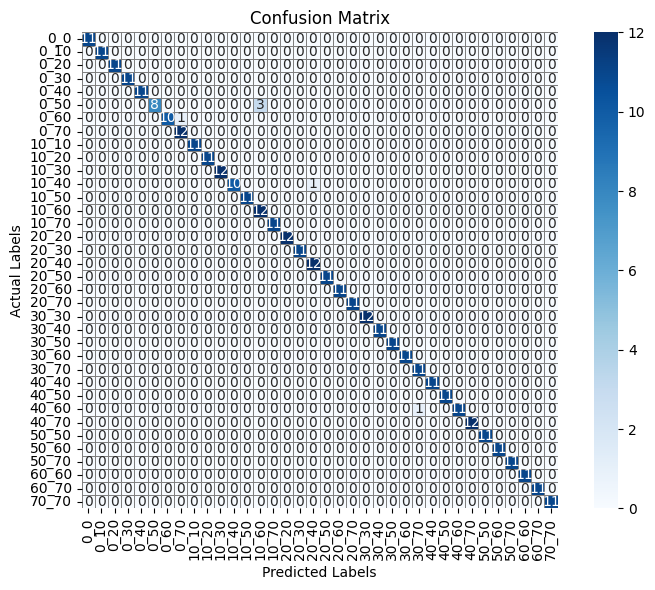

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.0896 - loss: 3.3445 - val_accuracy: 0.7988 - val_loss: 0.7989
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5809 - loss: 1.2431 - val_accuracy: 0.9443 - val_loss: 0.2090
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7755 - loss: 0.6370 - val_accuracy: 0.9659 - val_loss: 0.1105
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8208 - loss: 0.4819 - val_accuracy: 0.9690 - val_loss: 0.1209
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8558 - loss: 0.4120 - val_accuracy: 0.9721 - val_loss: 0.1104
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8740 - loss: 0.3510 - val_accuracy: 0.9814 - val_loss: 0.0541
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8915 - loss: 0.3142 - val_accuracy: 0.9690 - val_loss: 0.0721
Epoch 8/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8912 - loss: 0.3063 - val_accuracy: 0.9814 - val

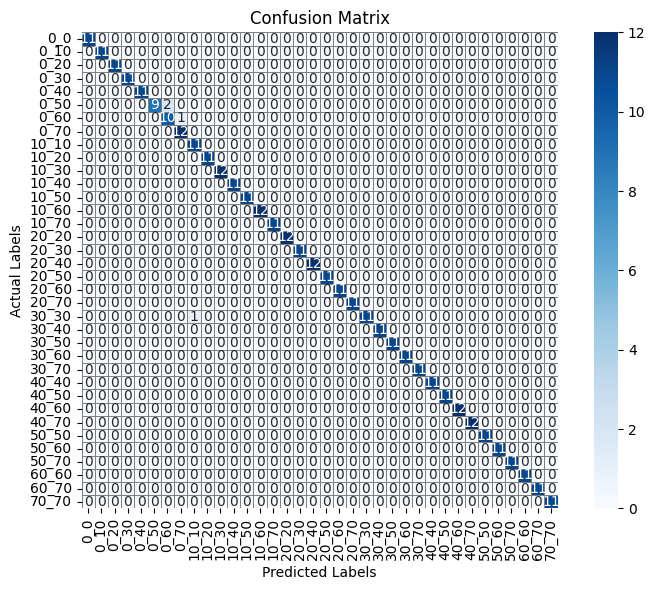

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.0687 - loss: 3.4347 - val_accuracy: 0.7059 - val_loss: 1.0070
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5622 - loss: 1.4153 - val_accuracy: 0.9288 - val_loss: 0.1803
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7911 - loss: 0.5885 - val_accuracy: 0.9659 - val_loss: 0.0855
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8475 - loss: 0.4224 - val_accuracy: 0.9690 - val_loss: 0.0733
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8887 - loss: 0.3345 - val_accuracy: 0.9938 - val_loss: 0.0502
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9003 - loss: 0.2796 - val_accuracy: 0.9814 - val_loss: 0.0530
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9176 - loss: 0.2377 - val_accuracy: 0.9814 - val_loss: 0.0553
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9234 - loss: 0.2056 - val_accuracy: 0.9814 - v

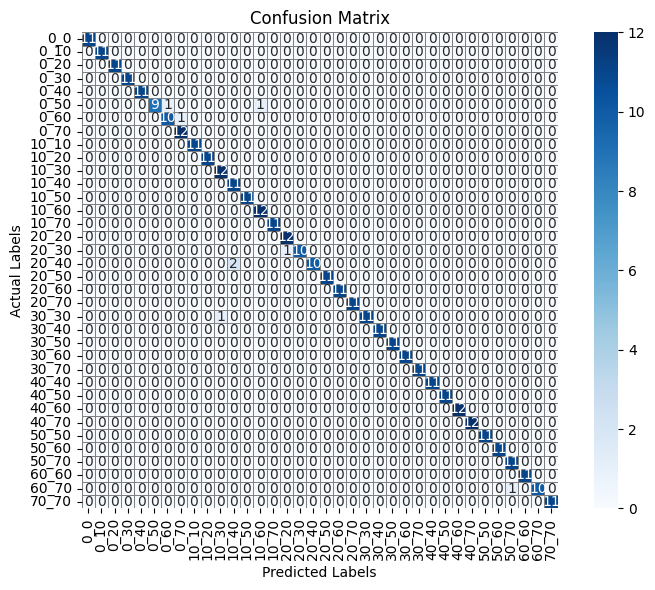

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.0227 - loss: 3.5852 - val_accuracy: 0.0279 - val_loss: 3.5826
Epoch 2/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0301 - loss: 3.5838 - val_accuracy: 0.0217 - val_loss: 3.5802
Epoch 3/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0344 - loss: 3.5821 - val_accuracy: 0.0402 - val_loss: 3.5742
Epoch 4/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0390 - loss: 3.5778 - val_accuracy: 0.0372 - val_loss: 3.5709
Epoch 5/5
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0384 - loss: 3.5662 - val_accuracy: 0.0495 - val_loss: 3.5678
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.0282 - loss: 3.6227
Test Loss: 3.6090359687805176
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Test Accuracy: 0.0297029702970297
Test Precision: 0.005122301236048555
Test Recall: 0.0297029702970297
Test F1 Score: 0.008551680602656382


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


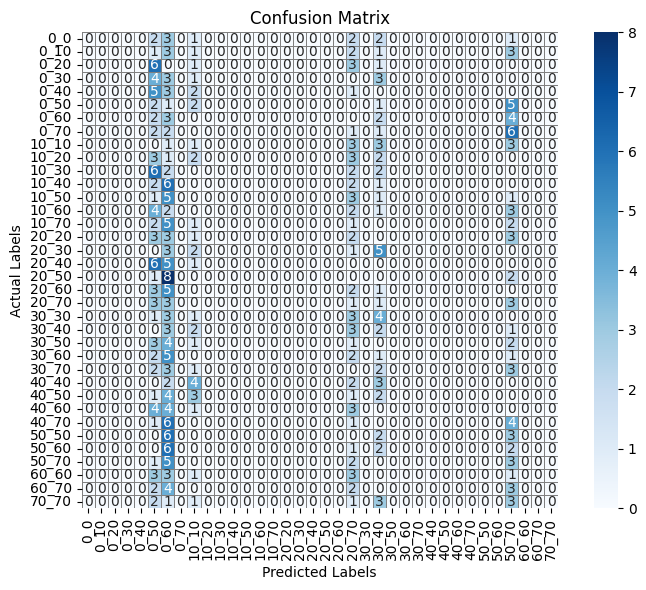

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.0258 - loss: 3.5848 - val_accuracy: 0.0279 - val_loss: 3.5828
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0260 - loss: 3.5843 - val_accuracy: 0.0279 - val_loss: 3.5797
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0304 - loss: 3.5823 - val_accuracy: 0.0186 - val_loss: 3.5851
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0364 - loss: 3.5755 - val_accuracy: 0.0155 - val_loss: 3.6129
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0406 - loss: 3.5616 - val_accuracy: 0.0526 - val_loss: 3.5933
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0474 - loss: 3.5499 - val_accuracy: 0.0464 - val_loss: 3.5942
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0540 - loss: 3.5284 - val_accuracy: 0.0650 - val_loss: 3.5689
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0553 - loss: 3.4956 - val_accuracy: 0.0310 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


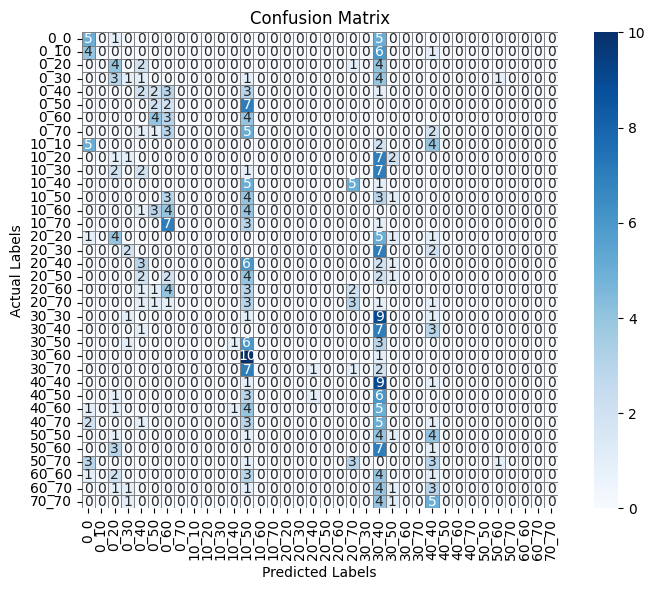

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.0247 - loss: 3.5856 - val_accuracy: 0.0279 - val_loss: 3.5825
Epoch 2/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0257 - loss: 3.5841 - val_accuracy: 0.0310 - val_loss: 3.5804
Epoch 3/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0229 - loss: 3.5831 - val_accuracy: 0.0186 - val_loss: 3.5790
Epoch 4/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0347 - loss: 3.5797 - val_accuracy: 0.0341 - val_loss: 3.5868
Epoch 5/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0408 - loss: 3.5646 - val_accuracy: 0.0433 - val_loss: 3.5837
Epoch 6/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0464 - loss: 3.5356 - val_accuracy: 0.0433 - val_loss: 3.5742
Epoch 7/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0553 - loss: 3.4987 - val_accuracy: 0.0464 - val_loss: 3.5025
Epoch 8/20
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0606 - loss: 3.4286 - val_accuracy: 0.0557 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


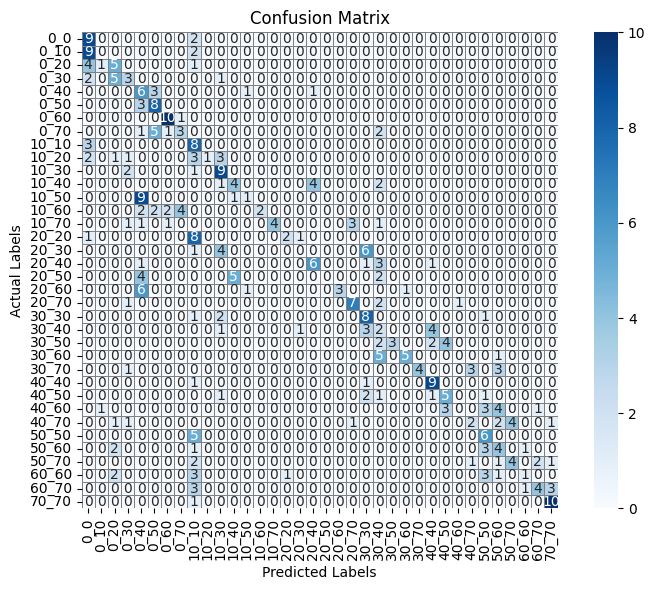

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


242/242 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.0261 - loss: 3.5848 - val_accuracy: 0.0279 - val_loss: 3.5832
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0255 - loss: 3.5850 - val_accuracy: 0.0186 - val_loss: 3.5823
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0226 - loss: 3.5836 - val_accuracy: 0.0279 - val_loss: 3.5824
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0287 - loss: 3.5833 - val_accuracy: 0.0217 - val_loss: 3.5836
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0311 - loss: 3.5799 - val_accuracy: 0.0186 - val_loss: 3.5849
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0329 - loss: 3.5750 - val_accuracy: 0.0279 - val_loss: 3.6113
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0361 - loss: 3.5623 - val_accuracy: 0.0402 - val_loss: 3.5859
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0550 - loss: 3.5358 - val_accuracy: 0.0310 - val

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


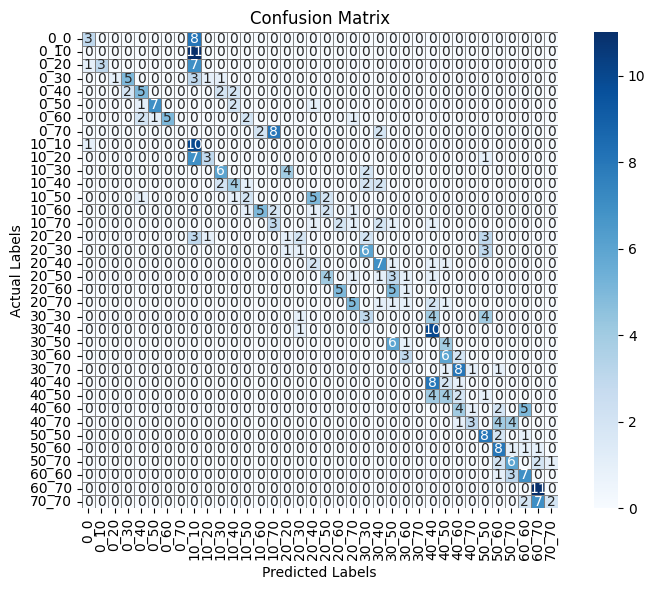

MODEL cnn2


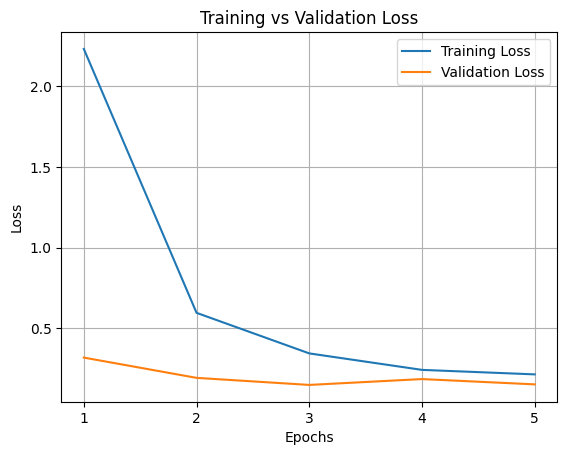

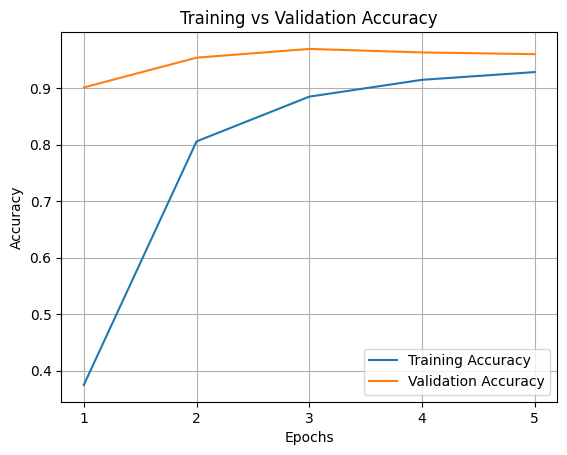

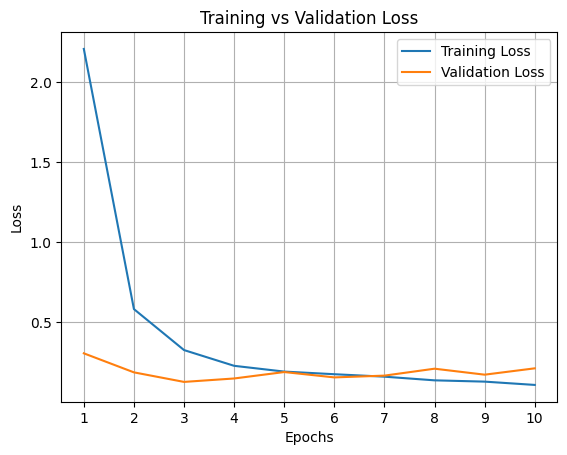

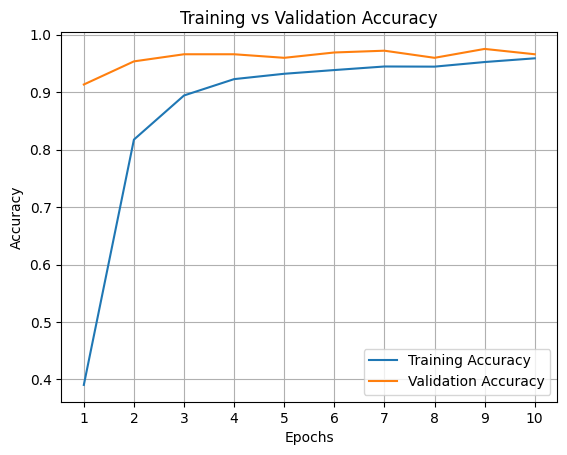

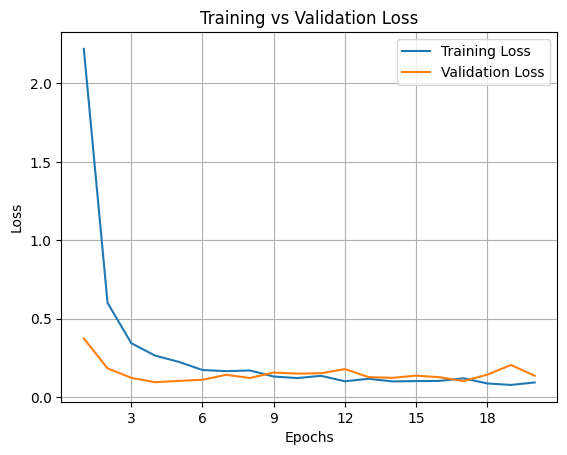

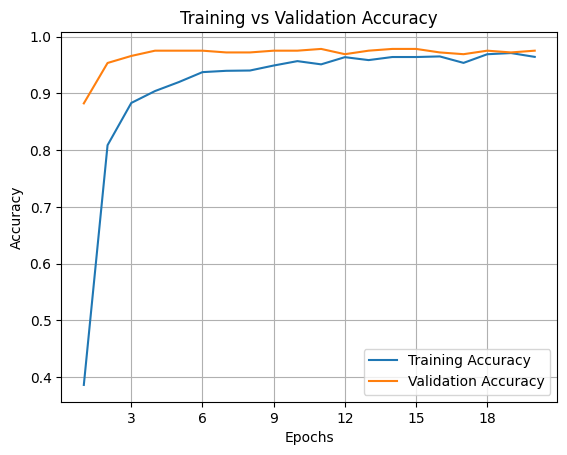

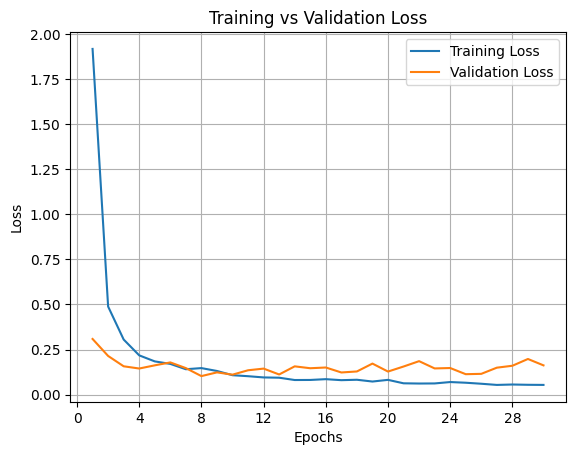

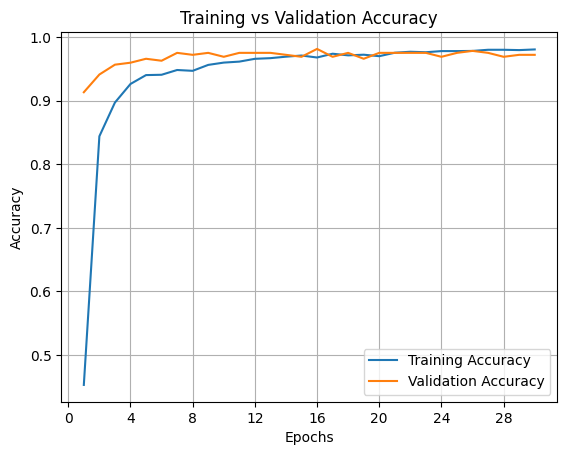

MODEL cnn2_


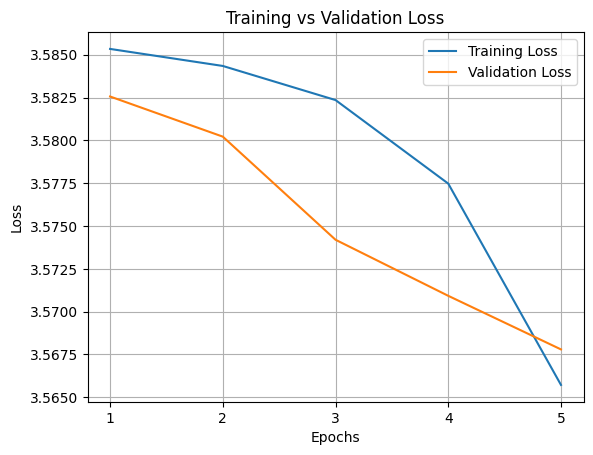

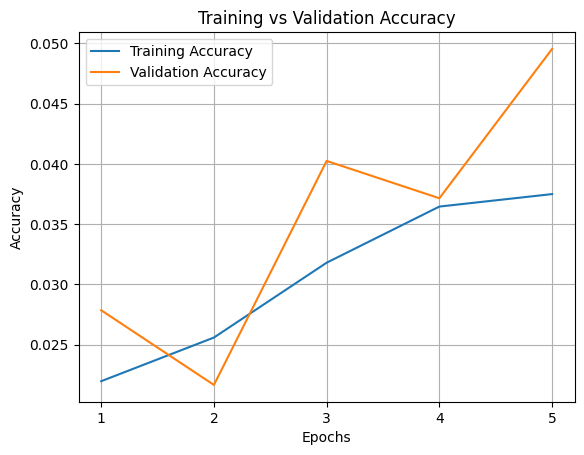

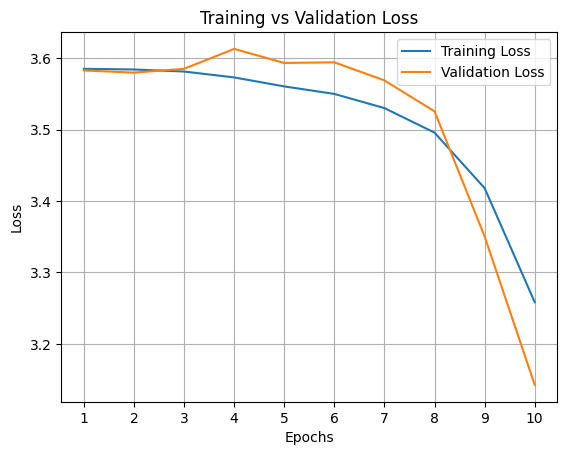

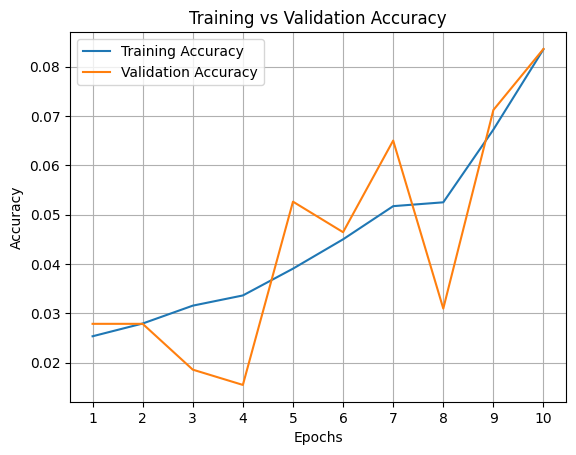

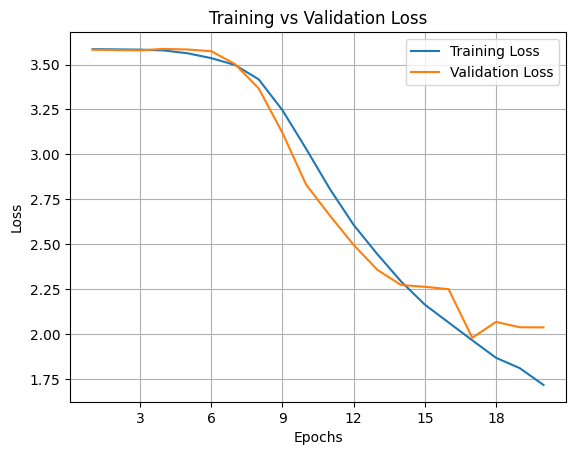

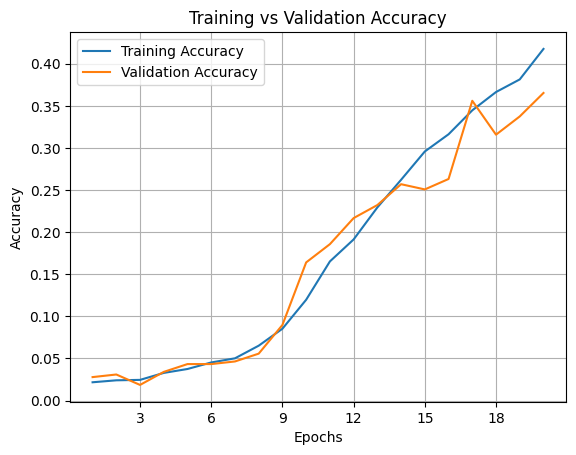

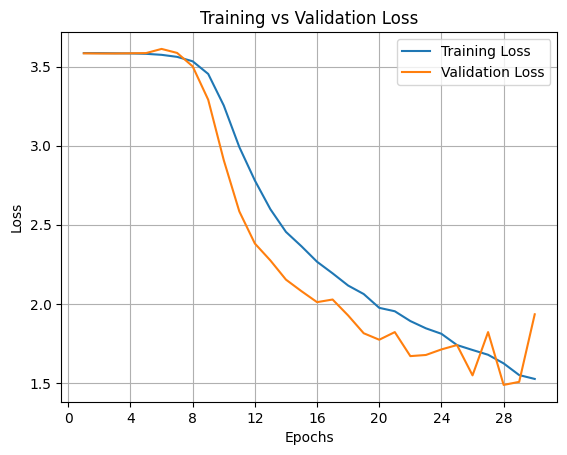

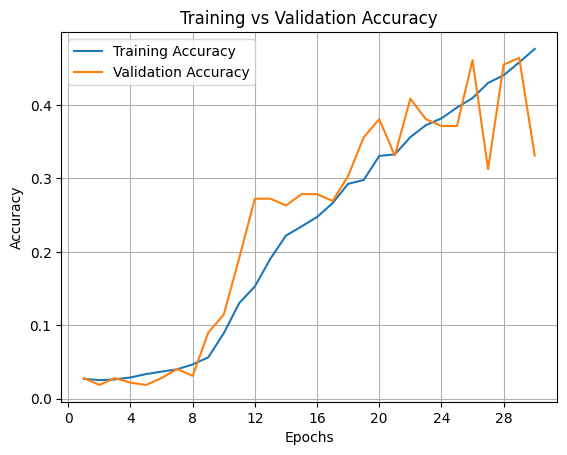

MODEL cnn3


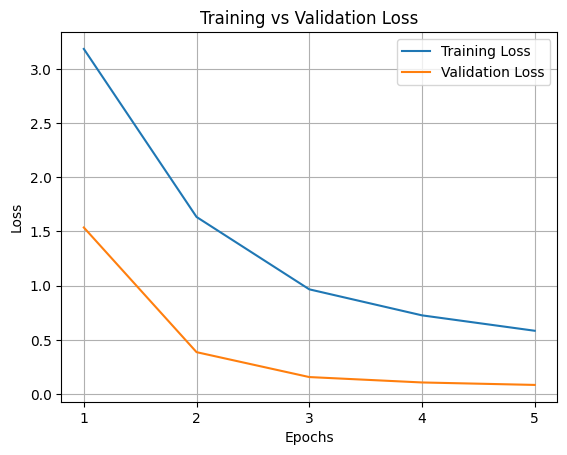

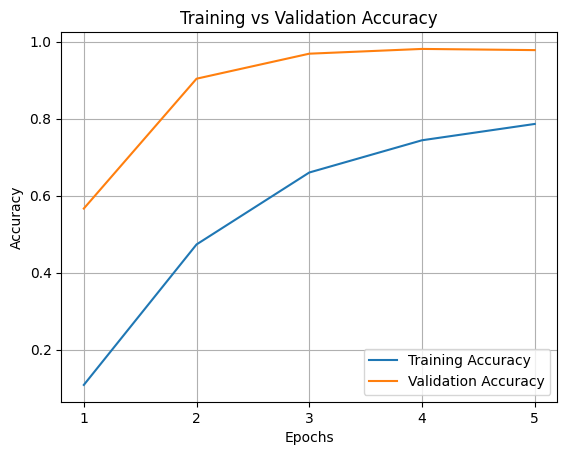

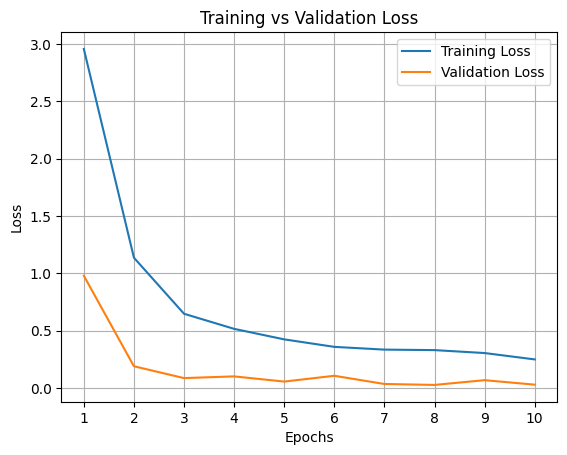

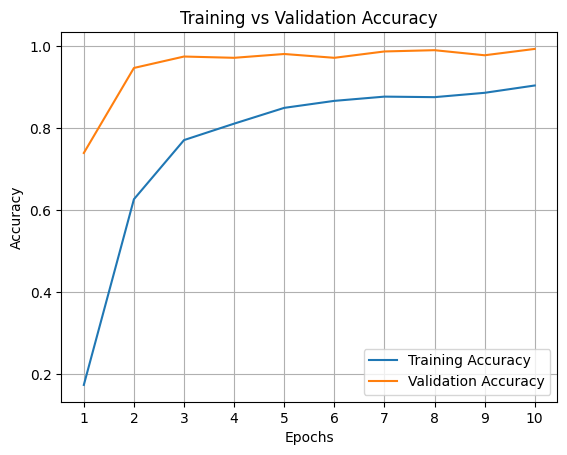

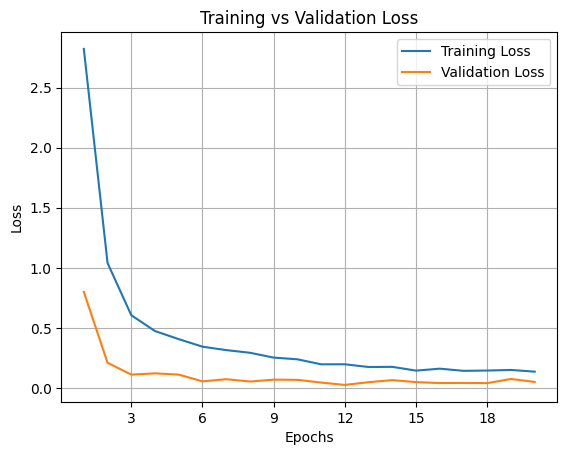

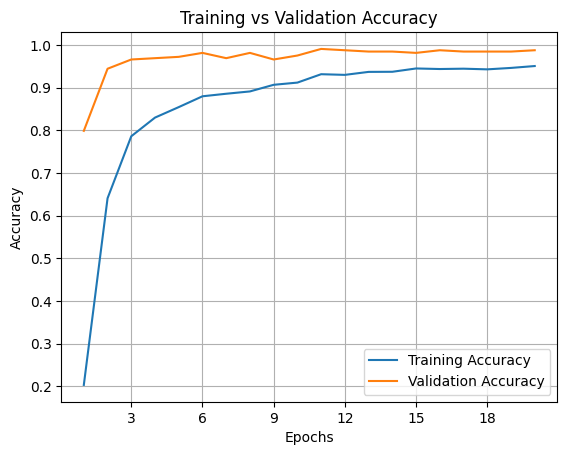

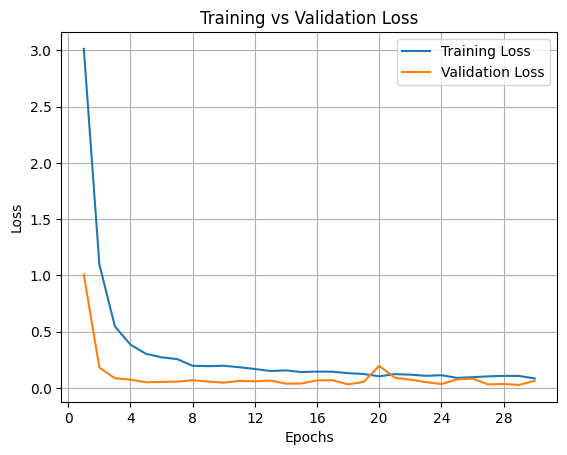

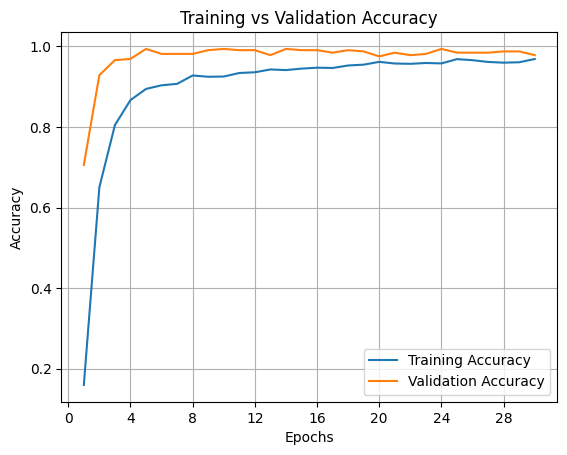

In [52]:
epochs = [5, 10, 20, 30]
data = []
model_history = {}

for model_type in ["cnn2", "cnn3", "cnn2_"]:
  model_history[model_type] = []
  for i, e in enumerate(epochs):

    model = get_model(name=model_type, input_shape=(None, None, 3), num_classes=36)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_dataset,
                        epochs=e, batch_size=BATCH_SIZE,
                        validation_data=val_dataset,
                        callbacks=[keras.callbacks.ModelCheckpoint(f'{model_type}' +"save_at_epoch{epoch}.keras")])

    model_history[model_type].append(history)

    acc, precision, recall, f1 = evaluate_model(model, labels, X_test, y_test, path=f"{FOLDER}/results/{model_type}-cm-ep{e}")
    data = store_results(data, model_type, {"epochs": e, "acc": acc, "precision": precision, "recall": recall, "f1": f1})

df = pd.DataFrame(data)
df.to_csv(f"{FOLDER}basic_cnns_results.csv", index=False)
plot_training_metrics(model_history, f"{FOLDER}/results/", save=True)

# Exploration: Data Augumentation => Instead of poses should we estimate the cos between pitch and roll?
---

The microrobot structure symetric => we can generate more poses by flipping images (the angle is the same):
*   pitch = a & flip across x-axis  => pitch = a
*   roll = a & flip across y-axis  => roll = a

In [ ]:
def aug_name(path, f):
  file = os.path.basename(path)
  file, ext = os.path.splitext(file)
  return f"{file}_{str(f)}{ext}"

def flip_image(path, flip):
  image = cv2.imread(path)
  return cv2.flip(image, flip)

def flip_and_store(p, r, specs, folder, df):
    flip, path, depth, h, w, chs = specs

    image = flip_image(path, flip)
    new_file = aug_name(path, flip)

    cv2.imwrite(f"{folder}{new_file}", image)
    df.append({"img": f"{folder}{new_file}",
                "label": f"{str(p)}_{str(r)}",
                "pitch": p,
                "roll": r,
                "depth": depth,
                "height": h,
                "width": w,
                "channels": chs})
    return  df

def copy_files(src, dest):
    for root, dirs, files in os.walk(src):
        for dir in dirs:
          for _, _, files in os.walk(f"{src}/{dir}/"):
            for file in files:
              shutil.copy2(f"{src}/{dir}/{file}", f"{dest}/{dir}/{file}")

In [ ]:
AUG_FOLDER = f"{FOLDER}extra/"
os.makedirs(AUG_FOLDER, exist_ok=True)

In [ ]:
angles = [0, 10, 20, 30, 40, 50, 60, 70]

df_extra = []
df_extra_neg = []

for p in angles:
  for r in angles:
    label = f"{p}_{r}"
    tmp = df[df["label"] == label]

    if len(tmp) == 0:
      continue

    folder = f"{AUG_FOLDER}{p}_{r}/"
    os.makedirs(folder, exist_ok=True)

    for row in tmp.iterrows():
      row  = row[1]
      specs = [row[0]] + list(row[4:])

      if p != 0:
          df_extra = flip_and_store(p, r, [0] + specs, folder, df_extra)
      if r != 0:
          df_extra = flip_and_store(p, r, [1] + specs, folder, df_extra)
      if p != 0 and r != 0:
          df_extra = flip_and_store(p, r, [-1] + specs, folder, df_extra)

df_extra = copy_files(f"{FOLDER}data/", f"{FOLDER}extra/")

df_extra = pd.concat([df, df_extra], ignore_index=True)
df_extra = pd.DataFrame(df_extra)

df_extra.to_csv(f"{FOLDER}extra_img_desc.csv")

<ipython-input-104-a08f1fc47f36>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  specs = [row[0]] + list(row[4:])


Visualization of negative rotations

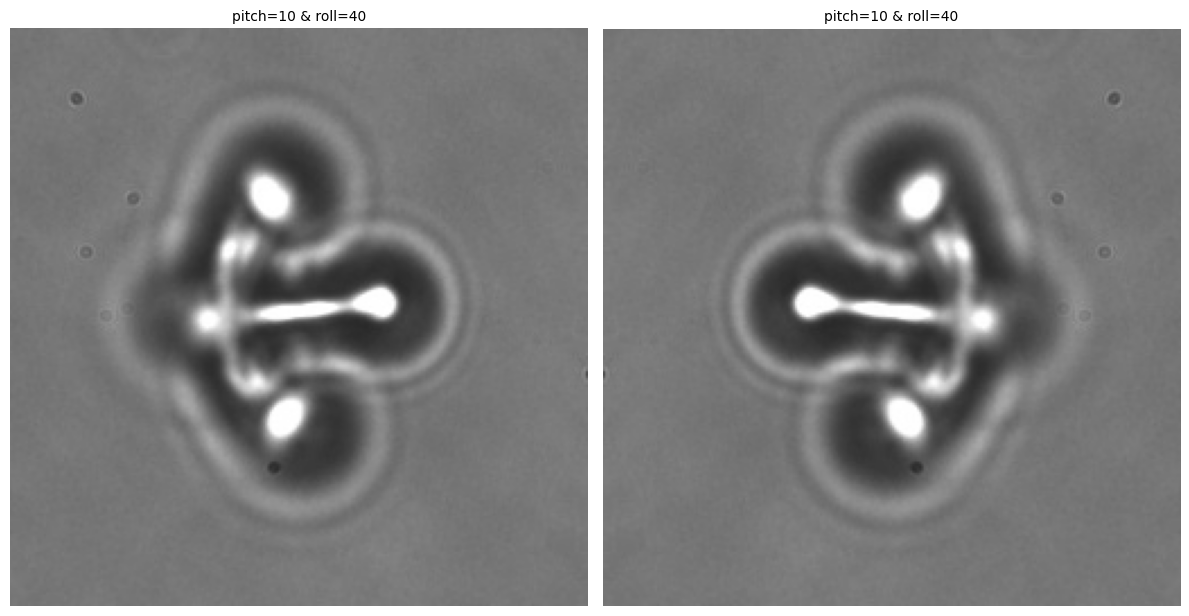

In [ ]:
df_extra = pd.read_csv(f"{FOLDER}extra_img_desc.csv")
pitch_roll_combs = [(0, 70), (0, 70)]
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes = axes.flatten()

label = f"0_40"
tmp = df[df["label"] == label]
img = mpimg.imread(tmp["img"].values[0])
axes[0].imshow(img, cmap='gray')
axes[0].axis('off')
axes[0].set_title(f"pitch={10} & roll={40}", fontsize=10)

tmp = df_extra[df_extra["img"] == f"{AUG_FOLDER}{label}/{aug_name(tmp['img'].values[0], 1)}"]
img = mpimg.imread(tmp["img"].values[0])
axes[1].imshow(img, cmap='gray')
axes[1].axis('off')
axes[1].set_title(f"pitch={10} & roll={-40}", fontsize=10)

plt.tight_layout()
plt.savefig(f"{PLOTS_FOLDER}images_v2")
plt.show()

Get augumented data

In [ ]:
labels, pose_dataset = create_poses_dataset(dir=f"{FOLDER}extra", batch_size=16)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(pose_dataset, test_size=0.2, val_size=0.2, strat=True)

Found 7112 files belonging to 36 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.0959 - loss: 3.2901 - val_accuracy: 0.7214 - val_loss: 1.2320
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5341 - loss: 1.4678 - val_accuracy: 0.9104 - val_loss: 0.4127
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7292 - loss: 0.8079 - val_accuracy: 0.9200 - val_loss: 0.2870
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7860 - loss: 0.6135 - val_accuracy: 0.9464 - val_loss: 0.2104
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8201 - loss: 0.5019 - val_accuracy: 0.9508 - val_loss: 0.2119
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9452 - loss: 0.2054
Test Accuracy: 0.9444834589958191
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Test Accuracy: 0.9444834855938159
Test Precision: 0.9478507054638539
Test Recall: 0.9444834855938159
Test F1 Score: 0.9449249443844051


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1113 - loss: 3.2861 - val_accuracy: 0.7961 - val_loss: 0.9292
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6426 - loss: 1.1482 - val_accuracy: 0.9112 - val_loss: 0.3342
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8036 - loss: 0.6028 - val_accuracy: 0.9350 - val_loss: 0.2540
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8481 - loss: 0.4510 - val_accuracy: 0.9420 - val_loss: 0.2272
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8713 - loss: 0.3652 - val_accuracy: 0.9464 - val_loss: 0.2163
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8951 - loss: 0.3025 - val_accuracy: 0.9543 - val_loss: 0.1953
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9082 - loss: 0.2637 - val_accuracy: 0.9543 - val_loss: 0.2115
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9096 - loss: 0.2430 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.1109 - loss: 3.2503 - val_accuracy: 0.7654 - val_loss: 0.9659
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5943 - loss: 1.2897 - val_accuracy: 0.9051 - val_loss: 0.3513
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7582 - loss: 0.7393 - val_accuracy: 0.9367 - val_loss: 0.2574
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8195 - loss: 0.5407 - val_accuracy: 0.9376 - val_loss: 0.2367
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8548 - loss: 0.4227 - val_accuracy: 0.9490 - val_loss: 0.2029
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8705 - loss: 0.3651 - val_accuracy: 0.9508 - val_loss: 0.1983
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8886 - loss: 0.3161 - val_accuracy: 0.9508 - val_loss: 0.2056
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9071 - loss: 0.2813 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1148 - loss: 3.2863 - val_accuracy: 0.7707 - val_loss: 1.0555
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5764 - loss: 1.3223 - val_accuracy: 0.8946 - val_loss: 0.4281
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7277 - loss: 0.8204 - val_accuracy: 0.9253 - val_loss: 0.3085
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8106 - loss: 0.5768 - val_accuracy: 0.9341 - val_loss: 0.2830
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8291 - loss: 0.5088 - val_accuracy: 0.9376 - val_loss: 0.2407
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8475 - loss: 0.4249 - val_accuracy: 0.9455 - val_loss: 0.2504
Epoch 7/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8728 - loss: 0.3529 - val_accuracy: 0.9499 - val_loss: 0.2585
Epoch 8/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8836 - loss: 0.3437 - val_accuracy: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.0326 - loss: 3.5739 - val_accuracy: 0.0316 - val_loss: 3.5498
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0352 - loss: 3.5495 - val_accuracy: 0.0431 - val_loss: 3.5458
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0307 - loss: 3.5392 - val_accuracy: 0.0413 - val_loss: 3.5380
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0371 - loss: 3.5456 - val_accuracy: 0.0448 - val_loss: 3.5144
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0397 - loss: 3.5230 - val_accuracy: 0.0483 - val_loss: 3.4734
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0591 - loss: 3.4823
Test Accuracy: 0.054813772439956665
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Test Accuracy: 0.054813773717498245
Test Precision: 0.016831307768066312
Test Recall: 0.054813773717498245
Test F1 Score: 0.016909295622057348


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.0336 - loss: 3.5719 - val_accuracy: 0.0316 - val_loss: 3.5496
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0306 - loss: 3.5517 - val_accuracy: 0.0316 - val_loss: 3.5451
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0348 - loss: 3.5517 - val_accuracy: 0.0334 - val_loss: 3.5400
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0372 - loss: 3.5418 - val_accuracy: 0.0457 - val_loss: 3.5329
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0374 - loss: 3.5365 - val_accuracy: 0.0501 - val_loss: 3.5068
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0567 - loss: 3.5082 - val_accuracy: 0.0571 - val_loss: 3.4616
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0591 - loss: 3.4588 - val_accuracy: 0.1002 - val_loss: 3.3555
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0807 - loss: 3.3172 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.0287 - loss: 3.5704 - val_accuracy: 0.0316 - val_loss: 3.5482
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0262 - loss: 3.5530 - val_accuracy: 0.0316 - val_loss: 3.5447
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0277 - loss: 3.5504 - val_accuracy: 0.0316 - val_loss: 3.5439
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0345 - loss: 3.5454 - val_accuracy: 0.0360 - val_loss: 3.5327
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0417 - loss: 3.5345 - val_accuracy: 0.0299 - val_loss: 3.5144
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0412 - loss: 3.5144 - val_accuracy: 0.0483 - val_loss: 3.4818
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0523 - loss: 3.4815 - val_accuracy: 0.0615 - val_loss: 3.4151
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0761 - loss: 3.4063 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.0270 - loss: 3.5731 - val_accuracy: 0.0316 - val_loss: 3.5498
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.0335 - loss: 3.5546 - val_accuracy: 0.0413 - val_loss: 3.5445
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0336 - loss: 3.5453 - val_accuracy: 0.0404 - val_loss: 3.5360
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0405 - loss: 3.5358 - val_accuracy: 0.0413 - val_loss: 3.5160
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0375 - loss: 3.5224 - val_accuracy: 0.0483 - val_loss: 3.4854
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0553 - loss: 3.4895 - val_accuracy: 0.0879 - val_loss: 3.4160
Epoch 7/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0788 - loss: 3.3930 - val_accuracy: 0.0967 - val_loss: 3.2590
Epoch 8/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0924 - loss: 3.2649 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.0734 - loss: 3.3823 - val_accuracy: 0.6863 - val_loss: 1.1606
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5409 - loss: 1.4817 - val_accuracy: 0.9051 - val_loss: 0.4833
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6933 - loss: 0.9137 - val_accuracy: 0.9332 - val_loss: 0.2931
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7718 - loss: 0.6851 - val_accuracy: 0.9473 - val_loss: 0.2077
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8044 - loss: 0.5508 - val_accuracy: 0.9482 - val_loss: 0.1965
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9579 - loss: 0.1707
Test Accuracy: 0.9606465101242065
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test Accuracy: 0.960646521433591
Test Precision: 0.9617640014742962
Test Recall: 0.960646521433591
Test F1 Score: 0.9603933870109914


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.0743 - loss: 3.4182 - val_accuracy: 0.5211 - val_loss: 1.6901
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3976 - loss: 1.9024 - val_accuracy: 0.8638 - val_loss: 0.5940
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5903 - loss: 1.1917 - val_accuracy: 0.9271 - val_loss: 0.3125
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6927 - loss: 0.8699 - val_accuracy: 0.9297 - val_loss: 0.2726
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7269 - loss: 0.7605 - val_accuracy: 0.9420 - val_loss: 0.2356
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7592 - loss: 0.6625 - val_accuracy: 0.9385 - val_loss: 0.2316
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7830 - loss: 0.5898 - val_accuracy: 0.9420 - val_loss: 0.2232
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8083 - loss: 0.5366 - val_accuracy: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.0776 - loss: 3.3733 - val_accuracy: 0.7144 - val_loss: 1.2022
Epoch 2/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5273 - loss: 1.4677 - val_accuracy: 0.9077 - val_loss: 0.3936
Epoch 3/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7204 - loss: 0.7766 - val_accuracy: 0.9429 - val_loss: 0.2725
Epoch 4/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8173 - loss: 0.5472 - val_accuracy: 0.9429 - val_loss: 0.2488
Epoch 5/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8269 - loss: 0.4991 - val_accuracy: 0.9482 - val_loss: 0.2144
Epoch 6/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8543 - loss: 0.4064 - val_accuracy: 0.9482 - val_loss: 0.2000
Epoch 7/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8561 - loss: 0.3801 - val_accuracy: 0.9578 - val_loss: 0.1860
Epoch 8/20
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8654 - loss: 0.3631 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.0727 - loss: 3.4158 - val_accuracy: 0.6292 - val_loss: 1.5691
Epoch 2/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4533 - loss: 1.6861 - val_accuracy: 0.8858 - val_loss: 0.4524
Epoch 3/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6757 - loss: 0.9602 - val_accuracy: 0.9315 - val_loss: 0.2848
Epoch 4/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7270 - loss: 0.7775 - val_accuracy: 0.9499 - val_loss: 0.2123
Epoch 5/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7664 - loss: 0.6487 - val_accuracy: 0.9525 - val_loss: 0.2145
Epoch 6/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8030 - loss: 0.5436 - val_accuracy: 0.9613 - val_loss: 0.1805
Epoch 7/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8212 - loss: 0.4873 - val_accuracy: 0.9587 - val_loss: 0.1734
Epoch 8/30
285/285 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8386 - loss: 0.4509 - val_accuracy

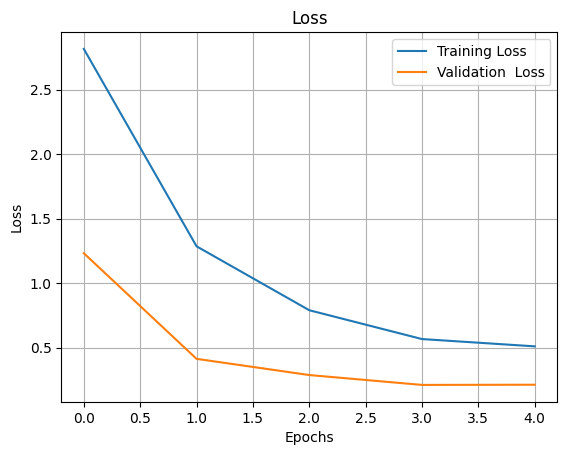

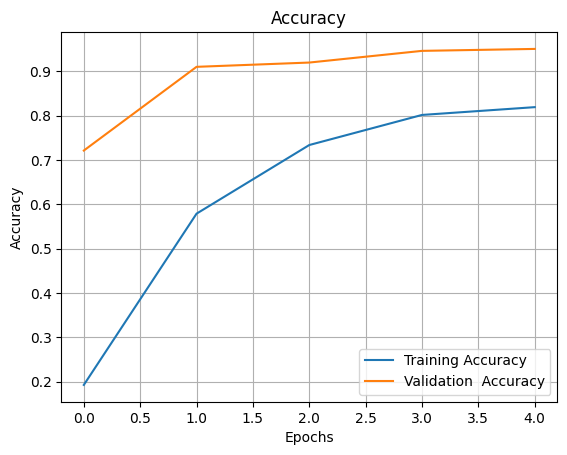

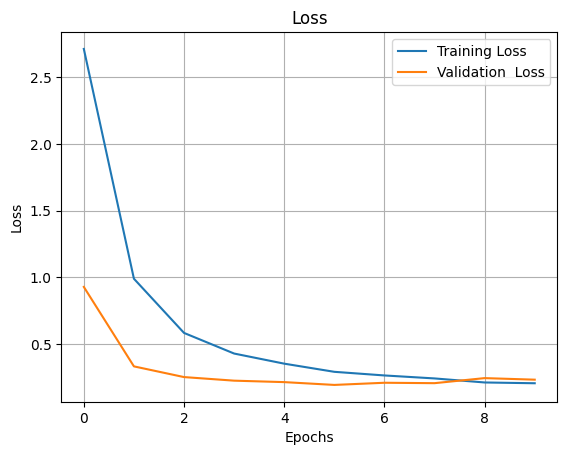

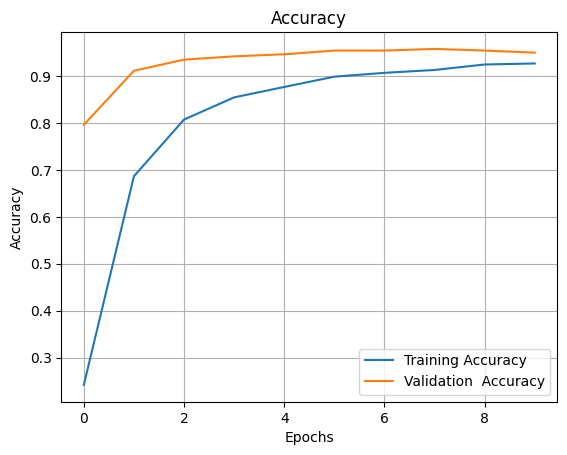

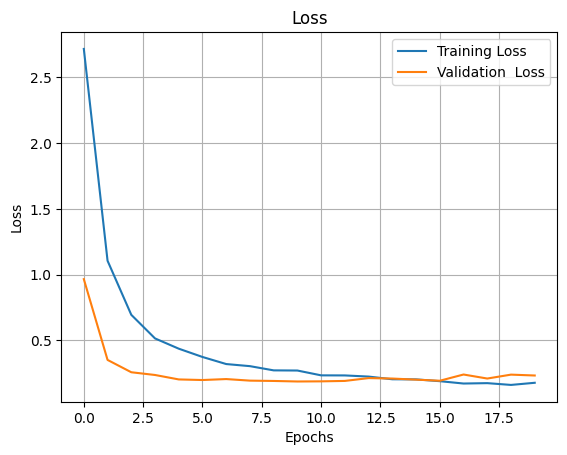

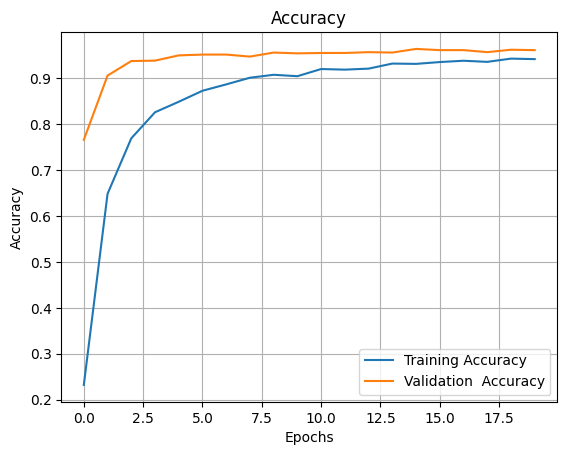

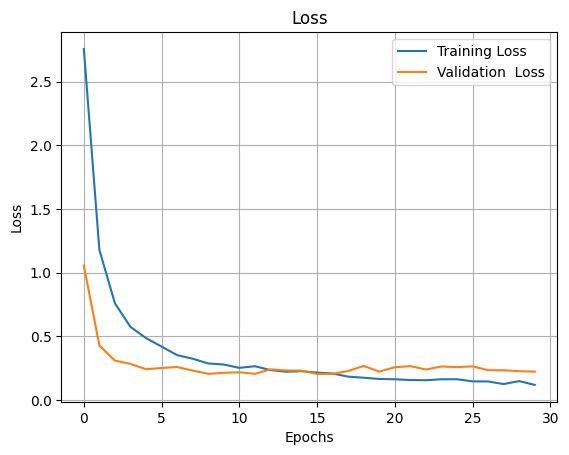

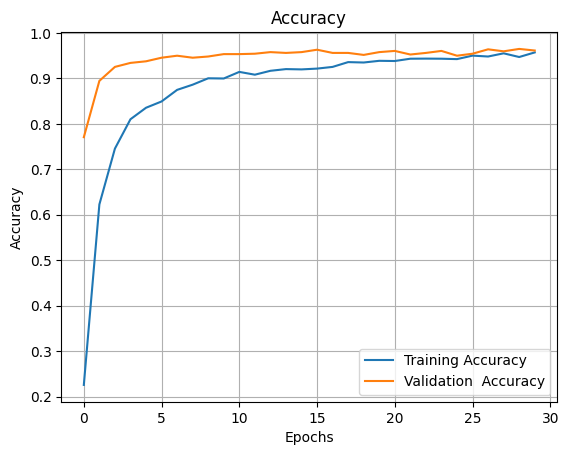

MODEL cnn2_


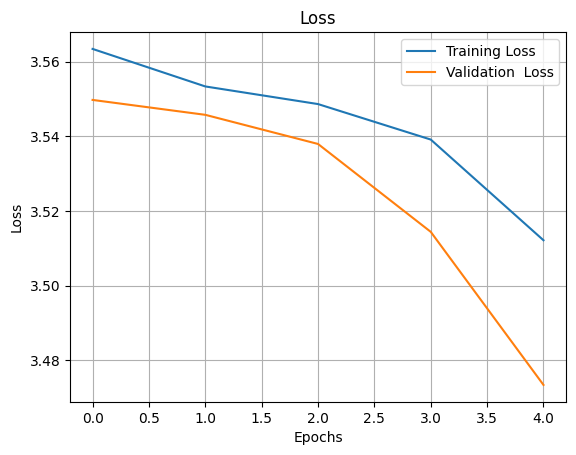

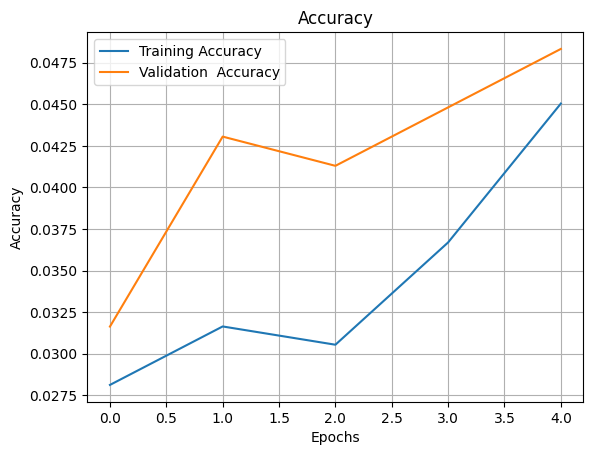

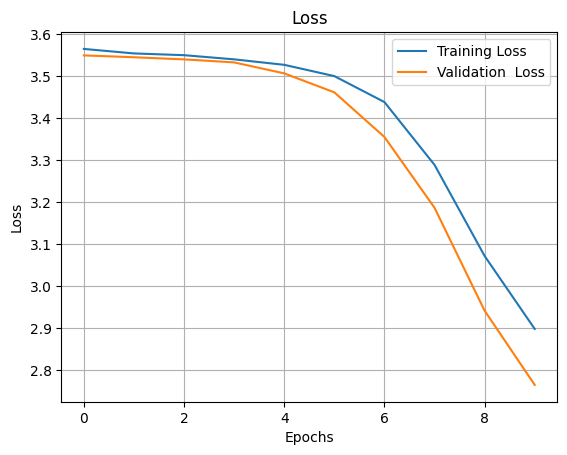

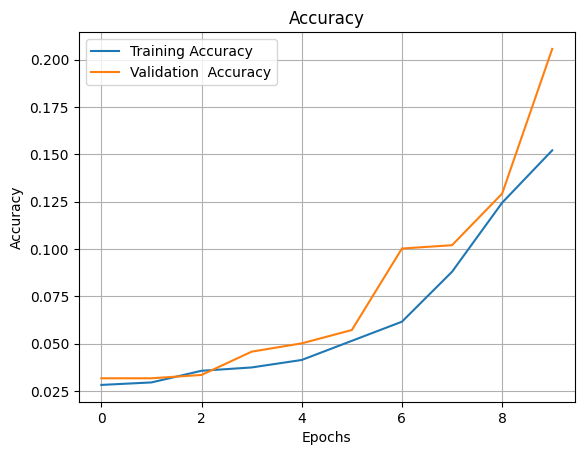

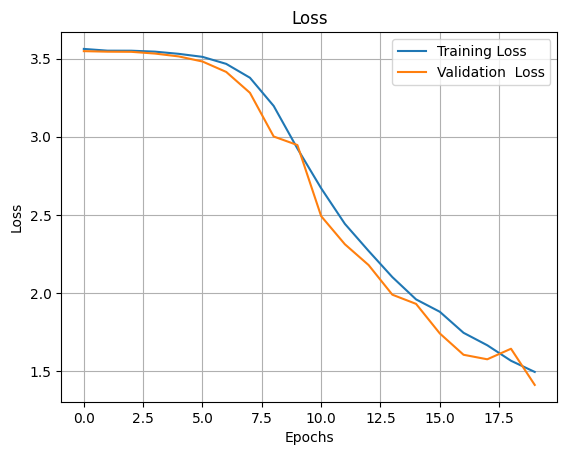

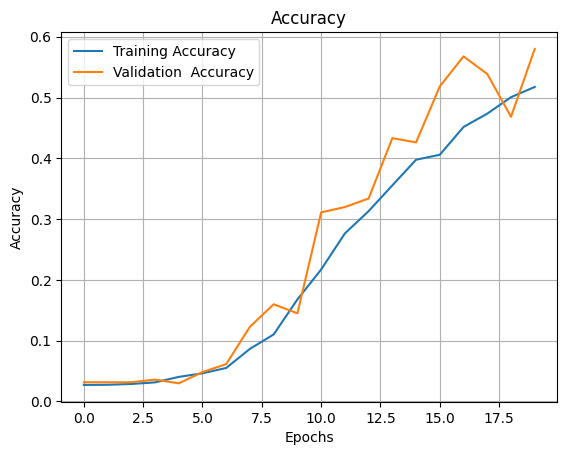

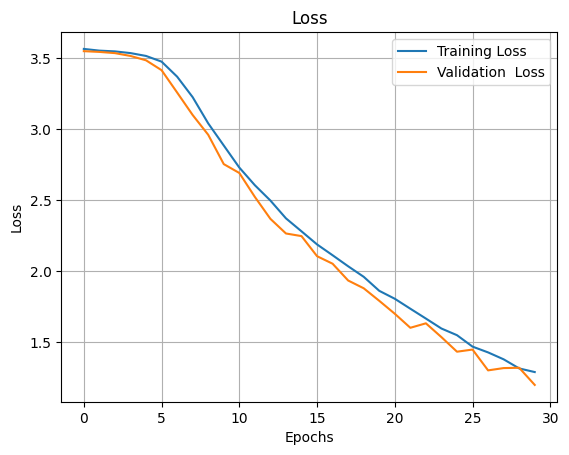

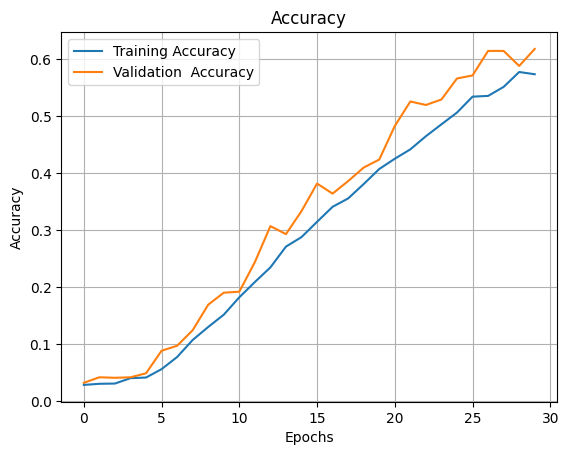

MODEL cnn3


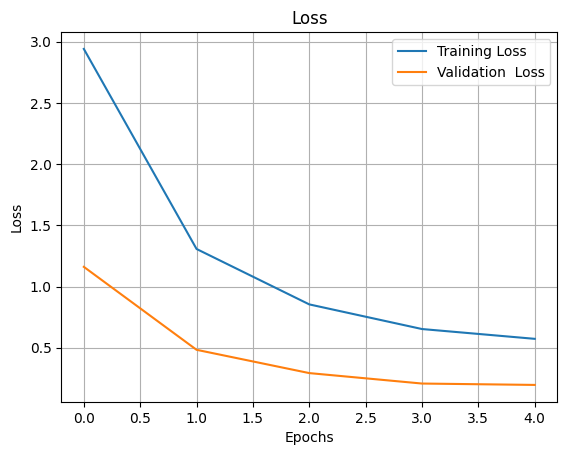

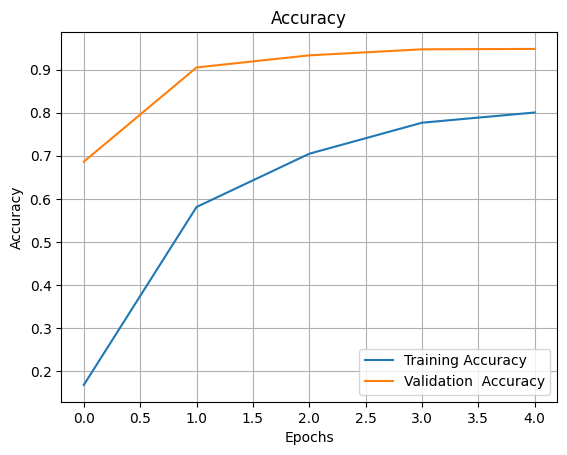

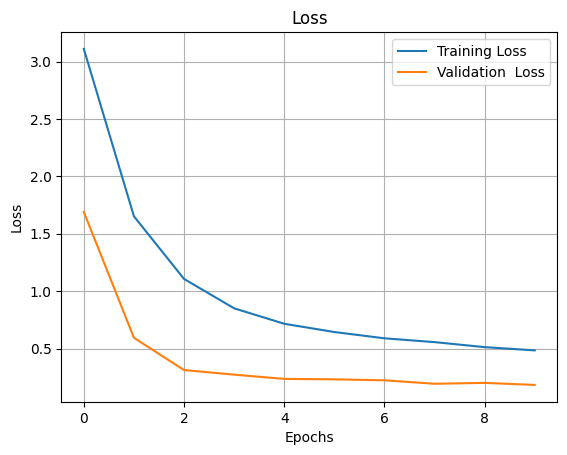

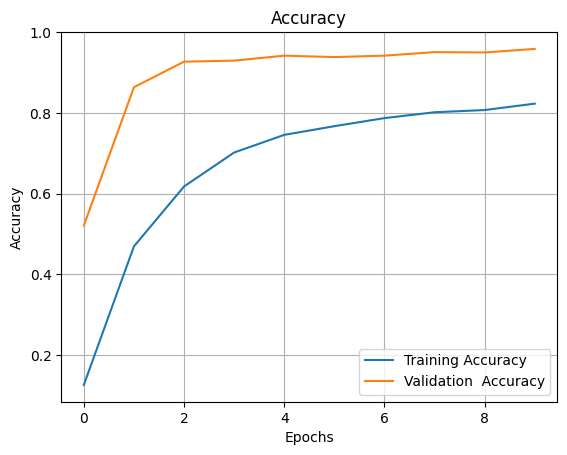

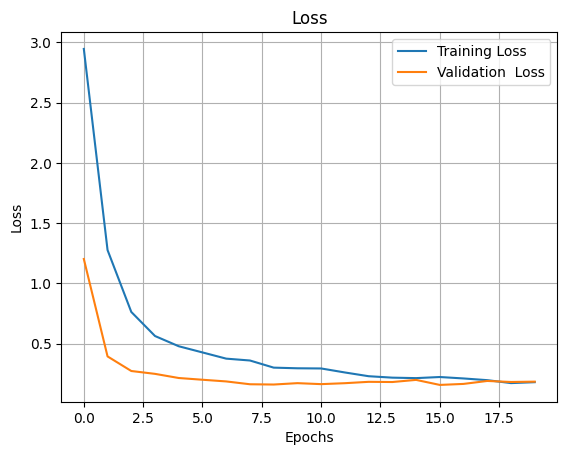

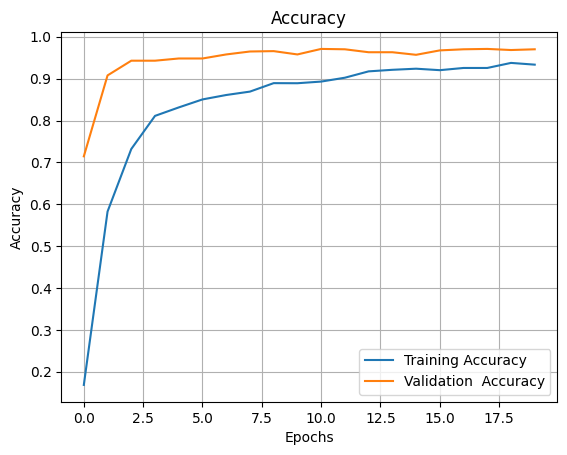

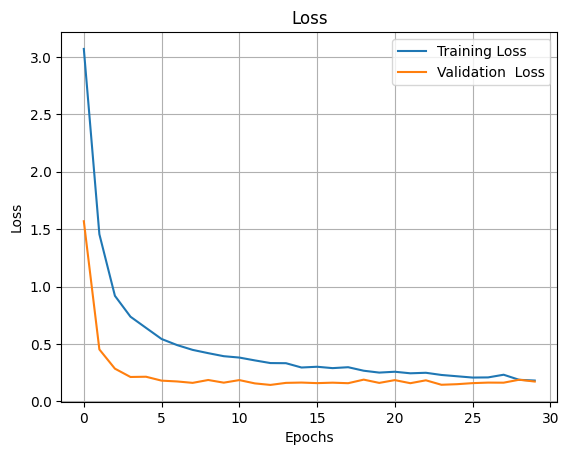

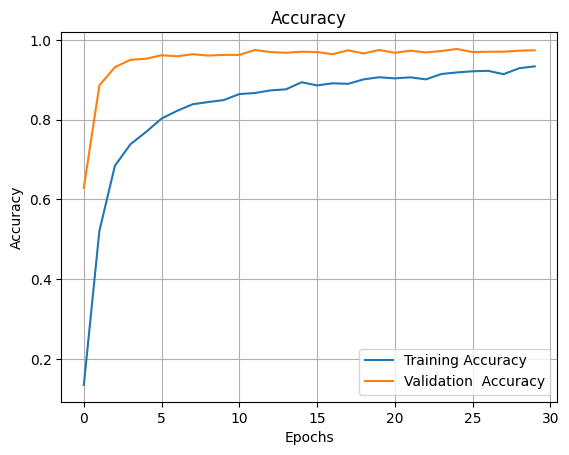

In [ ]:
epochs = [5, 10, 20, 30]
data = []
model_history = {}

for model_type in ["cnn2", "cnn2_", "cnn3"]:
  model_history[model_type] = []
  for i, e in enumerate(epochs):

    model = get_model(name=model_type, input_shape=(100, 100, 3), num_classes=36)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        epochs=e, batch_size=16,
                        validation_data=(X_val, y_val),
                        callbacks=[keras.callbacks.ModelCheckpoint(f'{model_type}' +"save_at_epoch{epoch}.keras")])

    model_history[model_type].append(history)

    acc, precision, recall, f1 = evaluate_model(model)

    data = store_results(data, model_type, {"epochs": e, "acc": acc, "precision": precision, "recall": recall, "f1": f1})

df = pd.DataFrame(data)
df.to_csv(f"{FOLDER}basic_cnns_results.csv", index=False)
plot_training_metrics(model_history, f"{FOLDER}/results/")